# Car crashes and weather

By Anthony Gerbier and Mathias Pisch

# Introduction

## Motivations

The objective of this study is to investigate the primary factors contributing to road accidents, with a particular focus on meteorological conditions.

Weather plays a crucial role in driver attention. Most drivers can recall days when heavy rainfall required heightened caution on the road. Similarly, media reports frequently highlight road conditions during snowfall in urban areas, such as Paris, where accident rates tend to increase.

Since changing weather conditions directly affect driving difficulty, it is natural to ask how they influence the occurrence of traffic accidents. Are certain weather conditions associated with a higher risk of accidents? To what extent do extreme weather events impact road safety?

These questions form the core of this study.

## Scientific Approach

To address these questions, we focus on a well-defined geographical area: Montgomery County, Maryland, chosen for its rich and detailed traffic accident dataset. Our aim is to identify the main factors contributing to road accidents, with a particular emphasis on weather. The study follows a structured experimental procedure.

First, the dataset undergoes thorough preprocessing to ensure completeness and consistency. This includes cleaning, handling missing values, and standardizing formats. Once prepared, the dataset is enriched with high-resolution meteorological data obtained via API calls. To respect API request limits and maintain efficiency, we perform this enrichment on a representative sample of Montgomery County accident records.

Next, we perform descriptive statistical analyses to explore the dataset, examine variable distributions, and identify potential patterns or correlations, particularly between weather variables and accident occurrences.

Finally, we proceed to a modeling stage aimed at quantifying the effect of weather on road accidents. Focusing on causal inference, we seek to determine whether specific weather conditions increase the likelihood of accidents, and to what extent. Regression-based methods are employed to estimate the marginal effect of each weather variable while controlling for other relevant factors. The ultimate goal is to provide a robust, data-driven understanding of how weather conditions influence road safety.

<a id="summary"></a>
## Summary
- [I. Installation](#installation)
- [II. Data Preparation](#data_preparation)
  - [1. Addresses](#url)
  - [2. Car Accidents in Maryland](#car_accidents)
    - [Loading](#download)
    - [Cleaning](#cleaning)
    - [Sampling](#sample)
  - [3. Weather Data](#weather)
    - [API Calls](#weather_api)
    - [Day/Night Variable](#day_or_night)
  - [4. Spatio-Temporal Grid](#grid)
    - [Grid creation](#grid_creation)
    - [API Calls](#grid_api)
    - [Average Values](#grid_average)
- [III. Descriptive Analysis](#descriptive)
  - [1. Construction of categorical variables](#categorical)
  - [2. Preliminary analysis of the new variables](#weather_analysis)
  - [3. Correlation between night and the percentage of accident with Driver Substance Abuse](#drogue)
  - [4. Plotting area map with multiple conditions ](#map)
  - [5. Descriptive Analysis of Injury Severity](#injury_desc)
  - [6. Weather and number of car crashes par day ](#crashes_per_day)

- [IV. Modeling](#modeling)
  - [1. Standardization of variables](#centrage)
  - [2. Multiple Linear Regression Analysis](#linear)
  - [3. Ordinal Regression Analysis](#ordinal)
  - [4. Regression of Daily Accidents](#daily_reg)
  - [5. Count-Based Modeling of Daily Accident Frequency](#count)

- [Conclusion and Perspectives](#conclusion)


<a id="installation"></a>
# I. Installation


## Libraries 

In [11]:
!pip install -r requirements.txt

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import openmeteo_requests
import requests_cache
from retry_requests import retry
from datetime import datetime, timezone, timedelta

import time
import calendar
import folium
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf

import nbformat

import geopandas as gpd

<a id="data_preparation"></a>
# II. Data Preparation
<a id="url"></a>
## II.1 Adresses

In [13]:
car_accidents_url = "https://data.montgomerycountymd.gov/api/views/mmzv-x632/rows.csv?accessType=DOWNLOAD"

weather_api_url = "https://archive-api.open-meteo.com/v1/archive"

## II.2 Car accidents in Montgomery County, Maryland <a id="car_accidents"></a>

The Crash Reporting – Drivers Data dataset from Montgomery County, Maryland, provides detailed information on motor vehicle drivers involved in traffic collisions occurring on county and local roadways. The dataset is compiled from the Automated Crash Reporting System (ACRS) of the Maryland State Police and includes reports submitted by multiple law enforcement agencies within the county, such as the Montgomery County Police and municipal police departments. It captures a wide range of variables related to crash events and driver characteristics, including collision context, driver behavior, and other attributes relevant to analysis of road safety. Because these reports are updated on a weekly basis and can be linked with other crash-related datasets via a common report identifier, the dataset offers a rich, longitudinal source of empirical data for studying patterns of traffic accidents and their determinants. Its granularity and scope make it particularly well-suited for investigating how meteorological conditions and other factors relate to accident severity and frequency within a defined geographic area. 

### II.2.i Download <a id="download"></a>


In [14]:
# this database takes approximately 2 to 4 min to download

bigbase = pd.read_csv(car_accidents_url)

bigbase.head()


/tmp/ipykernel_13983/3654576895.py:3: DtypeWarning: Columns (1,9) have mixed types. Specify dtype option on import or set low_memory=False.
  bigbase = pd.read_csv(car_accidents_url)


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,Location
0,MCP3126006X,250037402,MONTGOMERY,Injury Crash,08/21/2025 05:21:00 PM,Maryland (State) Route,NaN,NaN,NaN,NaN,...,Northbound,40,No,No,2013,KIA,SOUL,39.219796,-77.257416,"(39.219796, -77.25741635)"
1,MCP2349001B,250037516,MONTGOMERY,Property Damage Crash,08/22/2025 10:44:00 AM,Interstate (State),EISENHOWER MEMORIAL HWY,NaN,NaN,NaN,...,Northbound,55,No,No,0,NaN,NaN,39.180181,-77.250657,"(39.18018079, -77.25065714)"
2,MCP296500BC,250033157,MONTGOMERY,Property Damage Crash,07/25/2025 11:55:00 AM,Bicycle Route,NaN,NEW HAMPSHIRE AVE (SB/L) NORBECK RD (WB/L) SPE...,NaN,NaN,...,Westbound,40,No,No,2023,LEXUS,RX,39.121219,-76.988905,"(39.12121898, -76.98890509)"
3,MCP2159003K,250037509,MONTGOMERY,Property Damage Crash,08/22/2025 10:36:00 AM,Maryland (State) Route,NaN,NaN,NaN,NaN,...,Southbound,30,No,No,2003,TOYOTA,SIENNA,39.207931,-77.141480,"(39.20793083, -77.1414795)"
4,MCP312900D6,250034573,MONTGOMERY,Property Damage Crash,08/03/2025 02:10:00 PM,NaN,NaN,NaN,Parking Lot Way PARKING LOT OF 2741 UNI...,NaN,...,Not On Roadway,0,No,No,2023,SUBARU,IMPREZA,39.039662,-77.057238,"(39.03966248, -77.05723843)"


#### Version locale

In [15]:
"""import pandas as pd
import numpy as np

# Downloading the database
bigbase = pd.read_csv("Crash_Reporting_-_Drivers_Data.csv")

bigbase.head()"""

'import pandas as pd\nimport numpy as np\n\n# Downloading the database\nbigbase = pd.read_csv("Crash_Reporting_-_Drivers_Data.csv")\n\nbigbase.head()'

### II.2.ii Cleaning <a id="cleaning"></a>


In this section, we perform a comprehensive cleaning of the dataset to ensure its reliability and suitability for subsequent statistical analyses.

We begin by examining the structure of the dataset, with particular attention to the available variables, their data types, and their completeness. This initial inspection allows us to identify columns that are essential for the objectives of the study, as well as those that may be redundant or insufficiently documented.

Next, we remove observations containing missing values in key variables. These variables are defined based on their relevance to the analysis, particularly those related to accident characteristics, temporal information, location, and weather conditions. Since incomplete records may introduce bias or reduce statistical power, rows with missing values in these critical fields are excluded from the analysis.

Finally, we address the presence of outliers. Given that this dataset is compiled from police accident reports, reporting or data entry errors are possible. Such errors may result in implausible or extreme values that do not reflect real-world conditions. We therefore identify and remove outliers using statistically motivated criteria, ensuring that the remaining observations fall within realistic and interpretable ranges.

#### Column Analysis

This subsection examines the values of each column in order to identify variable types (e.g., numerical or categorical) and assess the frequency of non-missing observations within the dataset.

In [16]:
bigbase.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Name',
       'Off-Road Description', 'Municipality', 'Related Non-Motorist',
       'Collision Type', 'Weather', 'Surface Condition', 'Light',
       'Traffic Control', 'Driver Substance Abuse',
       'Non-Motorist Substance Abuse', 'Person ID', 'Driver At Fault',
       'Injury Severity', 'Circumstance', 'Driver Distracted By',
       'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent',
       'Vehicle First Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Going Dir', 'Speed Limit',
       'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year', 'Vehicle Make',
       'Vehicle Model', 'Latitude', 'Longitude', 'Location'],
      dtype='object')

In [17]:
bigbase['Report Number'].value_counts()

Report Number
MCP229800RC    10
MCP2693003Q     9
MCP12130045     9
MCP32800050     9
MCP3156002F     8
               ..
MCP3168008G     1
MCP3304001X     1
MCP3304001Y     1
HA22280007      1
MCP33620062     1
Name: count, Length: 117105, dtype: int64

In [18]:
bigbase["Crash Date/Time"].value_counts()

Crash Date/Time
12/10/2018 06:10:00 PM    11
06/09/2020 06:53:00 PM    10
03/28/2019 09:30:00 AM    10
03/03/2017 06:00:00 AM    10
05/17/2017 03:36:00 PM     9
                          ..
12/04/2020 08:00:00 PM     1
06/26/2017 11:10:00 AM     1
09/24/2015 04:30:00 PM     1
05/06/2020 07:00:00 PM     1
09/10/2017 03:45:00 AM     1
Name: count, Length: 114243, dtype: int64

We can now be aware of the format of date we have to deal with

In [19]:
bigbase["Weather"].value_counts()

Weather
CLEAR                                116780
Clear                                 27945
RAINING                               20609
CLOUDY                                17295
Rain                                   3681
Cloudy                                 3187
SNOW                                   1444
UNKNOWN                                 693
FOGGY                                   676
WINTRY MIX                              391
OTHER                                   370
Snow                                    317
Unknown                                 234
SLEET                                   218
SEVERE WINDS                            154
BLOWING SNOW                            115
Blowing Snow                             76
Fog, Smog, Smoke                         64
Freezing Rain Or Freezing Drizzle        53
Severe Crosswinds                        27
BLOWING SAND, SOIL, DIRT                 15
Sleet Or Hail                            14
Name: count, dtype: int6

We observe that the weather variable does not provide quantitative information, preventing the assessment of whether meteorological conditions were exceptional. Consequently, enriching the dataset with quantitative weather variables obtained via an external API is both relevant and necessary.

In [20]:
bigbase["Circumstance"]

0            Followed Too Closely
1                             NaN
2                             NaN
3            Followed Too Closely
4                             NaN
                   ...           
207709                        NaN
207710                        NaN
207711           Improper Backing
207712                        NaN
207713    Too Fast For Conditions
Name: Circumstance, Length: 207714, dtype: object

The circumstance variable is an example of a feature that will not be exploited in this study, as its values are highly qualitative and a large proportion of observations are missing, limiting its usefulness for quantitative analysis.

In [21]:
bigbase["Driver Distracted By"].value_counts()

Driver Distracted By
NOT DISTRACTED                                       106718
UNKNOWN                                               32803
Not Distracted                                        23491
LOOKED BUT DID NOT SEE                                21546
Unknown                                                8405
INATTENTIVE OR LOST IN THOUGHT                         4320
OTHER DISTRACTION                                      3245
Other Action (looking away from task, etc.)             991
DISTRACTED BY OUTSIDE PERSON OBJECT OR EVENT            970
BY OTHER OCCUPANTS                                      418
OTHER CELLULAR PHONE RELATED                            372
OTHER ELECTRONIC DEVICE (NAVIGATIONAL PALM PILOT)       325
TALKING OR LISTENING TO CELLULAR PHONE                  282
NO DRIVER PRESENT                                       279
BY MOVING OBJECT IN VEHICLE                             212
EATING OR DRINKING                                      196
ADJUSTING AUDIO AND

The driver distracted by variable exhibits a very high diversity of values, indicating substantial heterogeneity in the recorded categories. While it may be used in the analysis, it is not considered a fundamental variable for this study.

In [22]:
bigbase["Injury Severity"].value_counts()

Injury Severity
NO APPARENT INJURY          141196
No Apparent Injury           27437
POSSIBLE INJURY              17481
SUSPECTED MINOR INJURY       11871
Suspected Minor Injury        3012
Possible Injury               2431
SUSPECTED SERIOUS INJURY      1414
Suspected Serious Injury       284
FATAL INJURY                   154
Fatal Injury                    37
Name: count, dtype: int64

The injury severity variable contains sufficiently explicit values to allow the creation of a categorical variable. This will enable the study of the effect of weather conditions on accident severity.

#### Removal of Rows with Missing Values

The most critical variables to monitor for missing values are Latitude and Longitude. Ensuring these fields are populated is essential, as valid coordinates are required for joining the dataset with external meteorological data via API calls.

In [23]:
subset = ["Latitude", "Longitude", "Vehicle Year", "Speed Limit", "Injury Severity", "Driver Substance Abuse"] # columns we want to clean

bigbase_clean = bigbase.dropna(subset=subset)

# Quick conclusion of the amount of row dropped : 
rows_dropped = len(bigbase) - len(bigbase_clean)
percentage = (rows_dropped / len(bigbase)) * 100
print(f"{rows_dropped} rows dropped ({percentage:.2f}% of the rows)")

33717 rows dropped (16.23% of the rows)


In [24]:
bigbase_clean[subset].head()

,Latitude,Longitude,Vehicle Year,Speed Limit,Injury Severity,Driver Substance Abuse
0,39.219796,-77.257416,2013,40,No Apparent Injury,"Not Suspect of Alcohol Use, Not Suspect of Dru..."
2,39.121219,-76.988905,2023,40,No Apparent Injury,"Not Suspect of Alcohol Use, Not Suspect of Dru..."
3,39.207931,-77.141480,2003,30,No Apparent Injury,"Not Suspect of Alcohol Use, Not Suspect of Dru..."
5,39.092734,-77.076470,2016,25,No Apparent Injury,"Not Suspect of Alcohol Use, Not Suspect of Dru..."
6,39.058466,-77.121265,2025,0,No Apparent Injury,"Not Suspect of Alcohol Use, Not Suspect of Dru..."


#### Analysis and Outlier Removal


We will examine the following variables: Latitude, Longitude, Vehicle Year, Speed Limit, Injury Severity, and Driver Substance Abuse to ensure that they do not contain implausible values (e.g., coordinates outside the state, inconsistent vehicle years, or other anomalous entries).

This step excludes observations with coordinates located outside the study county.

In [25]:
lat_min = 38.934343
lat_max = 39.353502
lon_min = -77.52768
lon_max = -76.888505

# Créer une copie filtrée pour éviter le SettingWithCopyWarning
bigbase_clean_step2 = bigbase_clean[
    (bigbase_clean['Latitude'] >= lat_min) &
    (bigbase_clean['Latitude'] <= lat_max) &
    (bigbase_clean['Longitude'] >= lon_min) &
    (bigbase_clean['Longitude'] <= lon_max)
].copy()

# Afficher le nombre de lignes supprimées
rows_removed = len(bigbase_clean) - len(bigbase_clean_step2)
print(f"Rows removed: {rows_removed} ({rows_removed / len(bigbase_clean) * 100:.2f}% of total)")
print(f"Rows remaining: {len(bigbase_clean_step2)}")


Rows removed: 153 (0.09% of total)
Rows remaining: 173844


We will now generate a diagram illustrating the frequency of each value for the selected variables. This visualization provides an overview of their distributions and also serves as a quick method for identifying potential outliers.

In [26]:
def plot_value_counts(df, variable, color='skyblue', figsize=(10,6)):
    """
    Plot a bar chart showing all unique values of a variable and their counts.

    Parameters:
    df : pandas.DataFrame
        The DataFrame containing the data.
    variable : str
        The name of the variable to analyze.
    color : str, optional
        Color of the bars (default is 'skyblue').
    figsize : tuple, optional
        Figure size (default is (10,6)).

    Returns:
    None
    """
    # Count the occurrences of each unique value
    value_counts = df[variable].value_counts().sort_index()

    # Plot the bar chart
    plt.figure(figsize=figsize)
    plt.bar(value_counts.index.astype(str), value_counts.values, color=color)
    plt.xlabel(variable)
    plt.ylabel('Count')
    plt.title(f'Value counts of {variable}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


Plotting value counts for: Vehicle Year


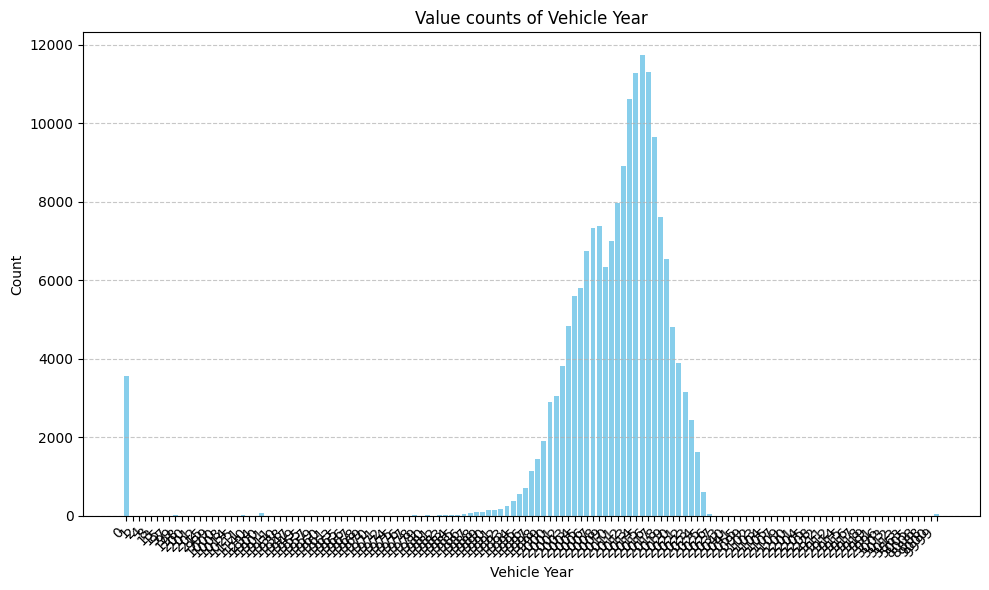

Plotting value counts for: Speed Limit


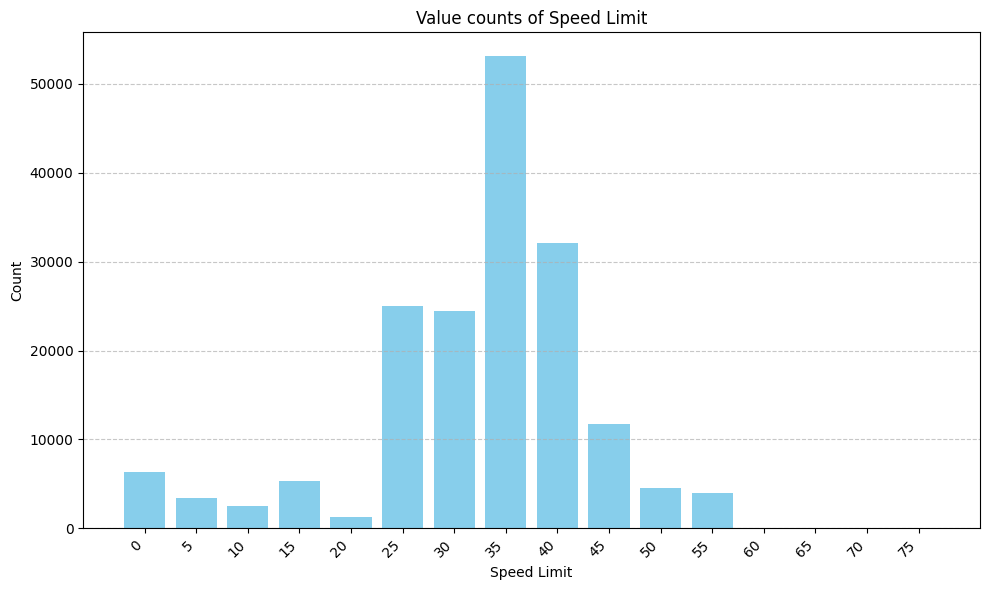

Plotting value counts for: Injury Severity


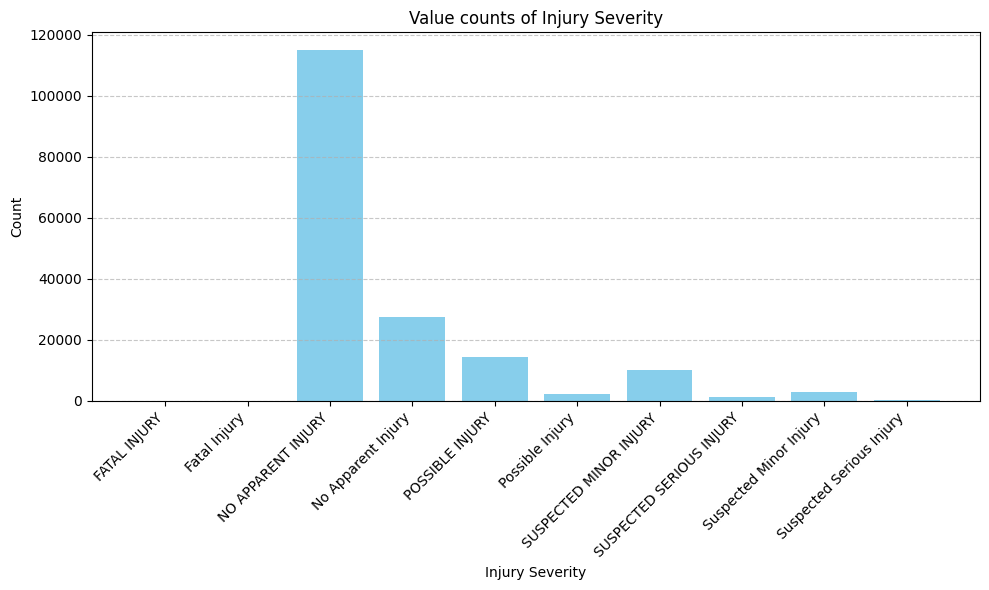

Plotting value counts for: Driver Substance Abuse


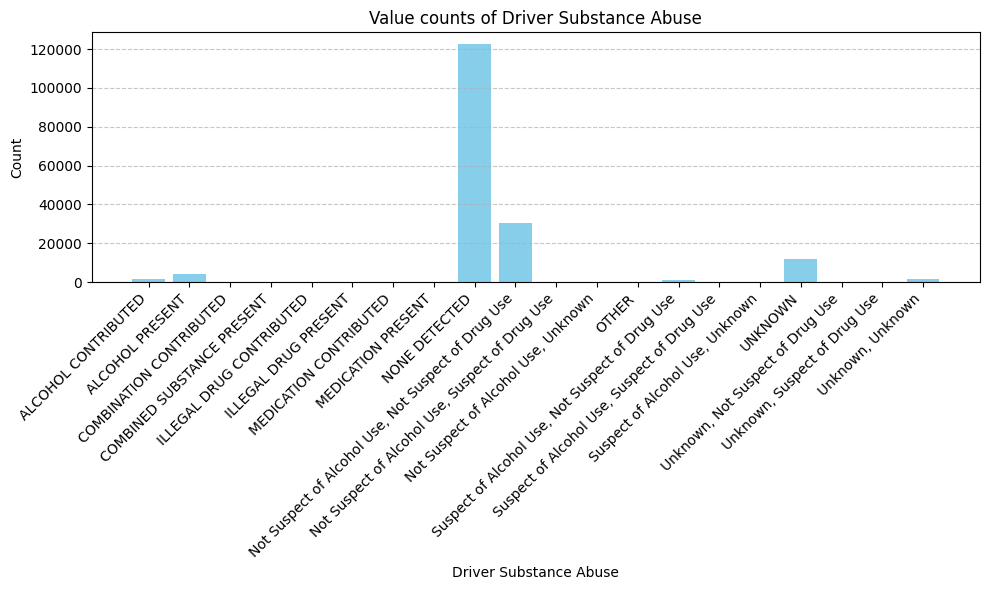

In [27]:
# List of columns to analyze
columns_to_analyze = ["Vehicle Year", "Speed Limit", "Injury Severity", "Driver Substance Abuse"]

# Loop over each column and plot its value counts
for col in columns_to_analyze:
    print(f"Plotting value counts for: {col}")
    plot_value_counts(bigbase_clean, variable=col)


We observe that the Vehicle Year variable contains implausible values, which will be removed from the dataset.

In [28]:
# Drop rows where Vehicle Year is less than 1920
bigbase_clean_step3 = bigbase_clean_step2[
    (bigbase_clean_step2['Vehicle Year'] >= 1950) &
    (bigbase_clean_step2['Vehicle Year'] <= 2025)
].copy()

# Vérification
print(f"Rows remaining: {len(bigbase_clean_step3)}")


Rows remaining: 170034


Let's plot again after this removal 

Plotting value counts for: Vehicle Year


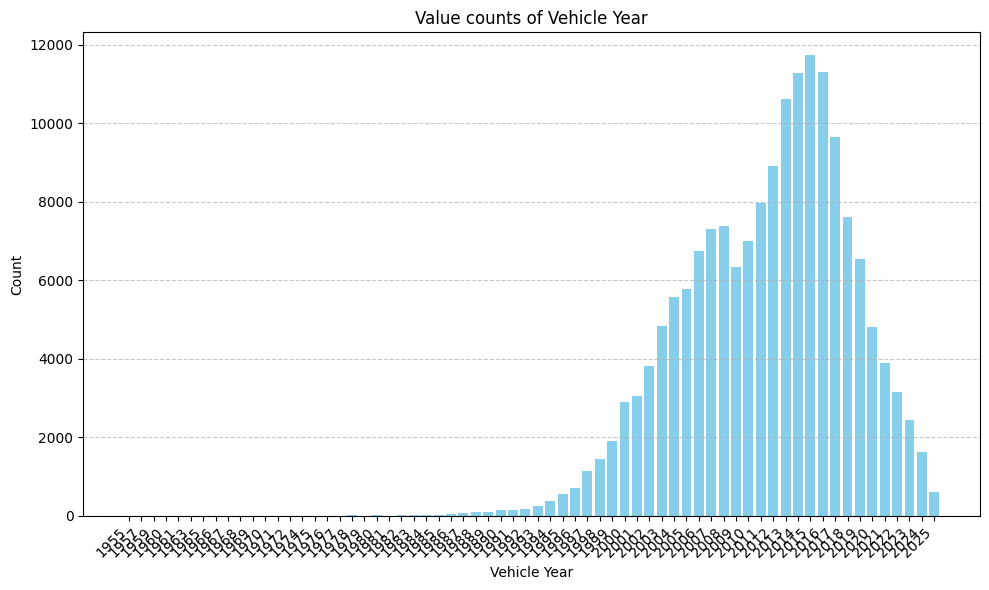

Plotting value counts for: Speed Limit


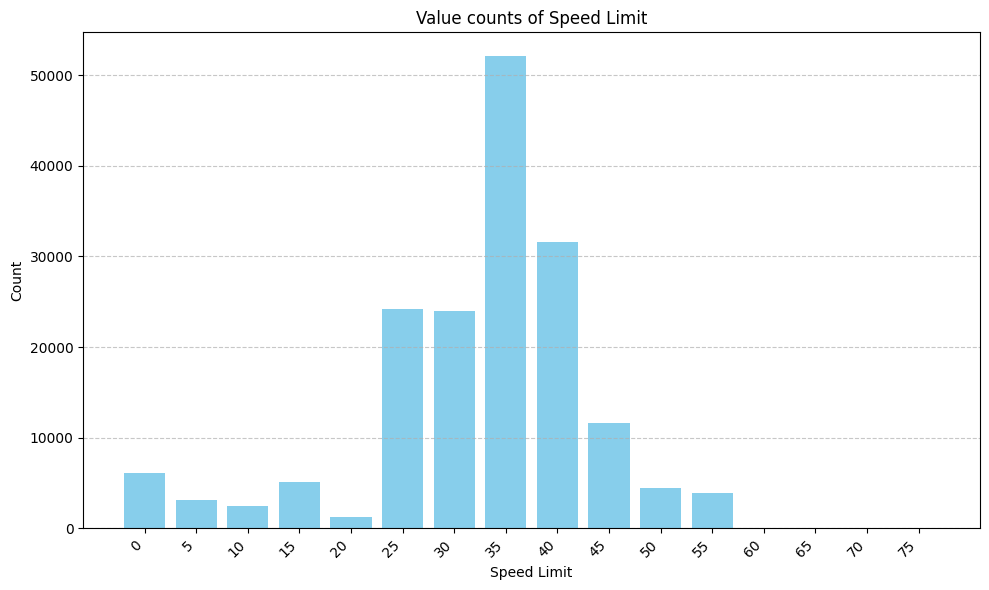

Plotting value counts for: Injury Severity


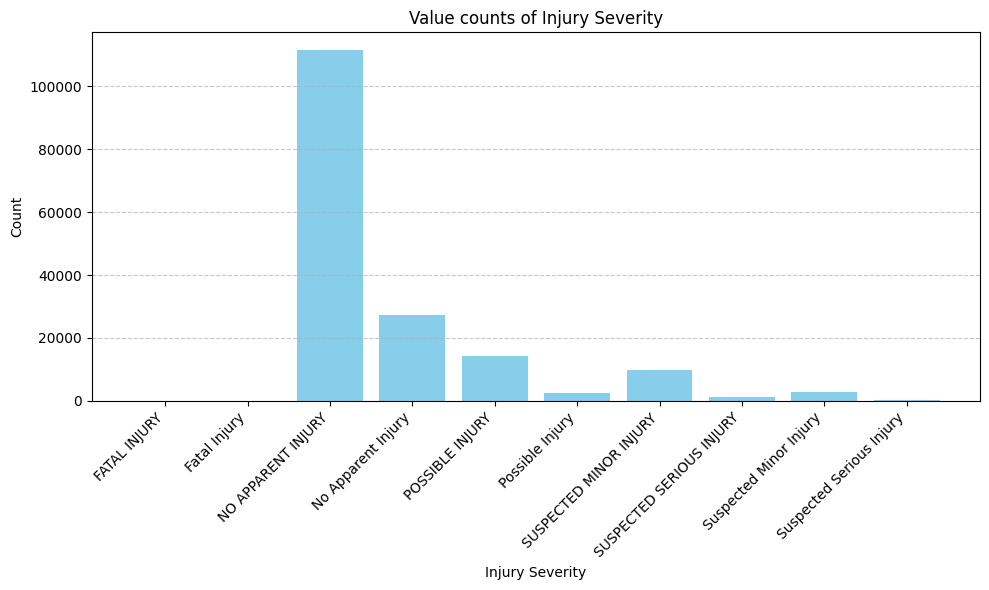

Plotting value counts for: Driver Substance Abuse


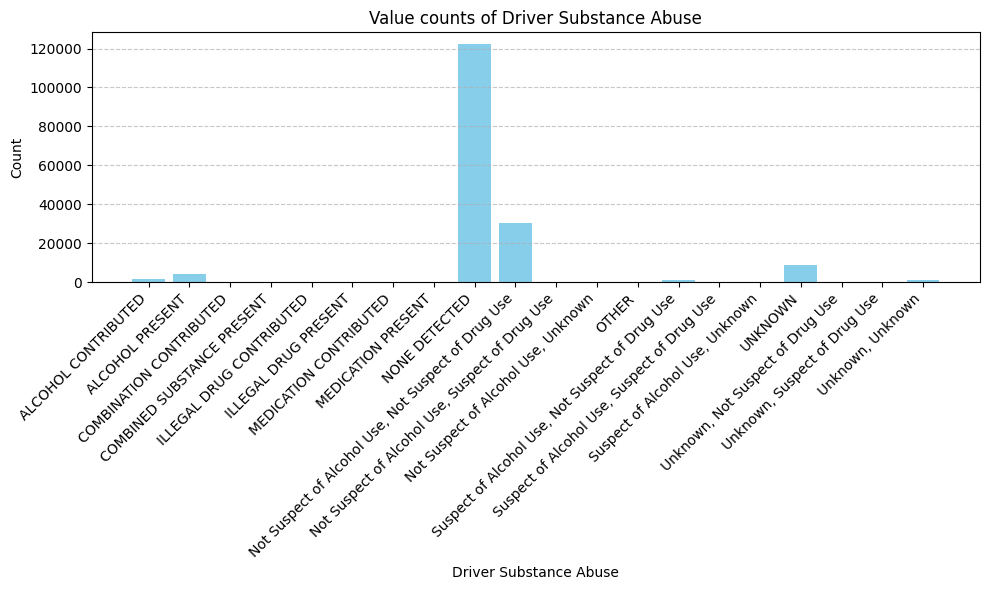

In [29]:
# List of columns to analyze
columns_to_analyze = ["Vehicle Year", "Speed Limit", "Injury Severity", "Driver Substance Abuse"]

# Loop over each column and plot its value counts
for col in columns_to_analyze:
    print(f"Plotting value counts for: {col}")
    plot_value_counts(bigbase_clean_step3, variable=col)


The implausible values have been successfully removed from the dataset.

Now, we will aggregate have been  into five-year intervals (e.g., 2010, 2015, 2020) to enhance visibility and facilitate interpretation. Here a 2014 vehicle falls into the 2010 category (Vehicle Cut = 2010), as years are grouped into five-year intervals for easier analysis.

Plotting value counts for: Vehicle Cutted in 5 years intervals


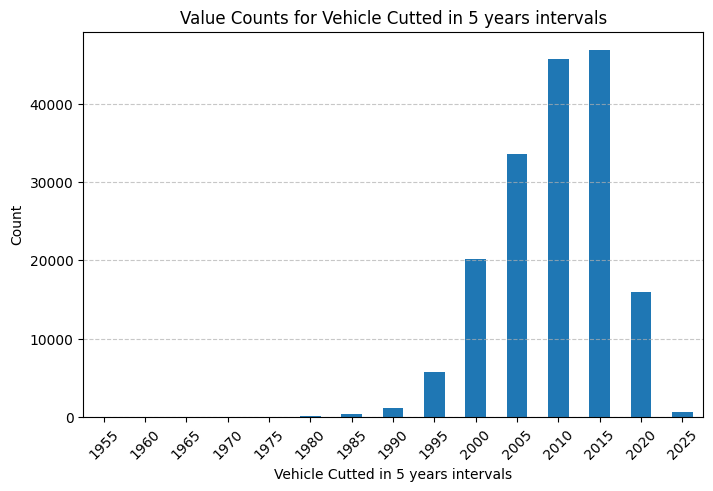

In [30]:

bigbase_clean_step3['Vehicle Cutted in 5 years intervals'] = (bigbase_clean_step3['Vehicle Year'] // 5 * 5).astype(int)

columns_to_analyze = ['Vehicle Cutted in 5 years intervals']

for col in columns_to_analyze:
    print(f"Plotting value counts for: {col}")
    counts = bigbase_clean_step3[col].value_counts().sort_index()
    
    plt.figure(figsize=(8,5))
    counts.plot(kind='bar')
    plt.title(f"Value Counts for {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.show()


The distribution indicates that the majority of vehicles in the dataset are relatively recent, with only a small proportion manufactured prior to the year 2000.

In [31]:
# We can now have the final version of our big database : 

bigbase_final=bigbase_clean_step3

### II.2.iii Sampling <a id="sample"></a>


We will perform a sampling of the dataset to facilitate the integration of meteorological data. This step is necessary because the number of API requests is limited per hour, and working with a representative subset ensures efficient data enrichment.

In [32]:
# We want to extract a sample of 6000 lines to make sure the data can be used properly. 

n_samples = min(6000, len(bigbase_final))
bigbase_sample = bigbase_final.sample(n=n_samples, random_state=42)  
bigbase_sample.to_csv("Montgomery_sample.csv", index=False)

print("Original shape:", bigbase_sample.shape)
bigbase_sample.head(100)

Original shape: (6000, 40)


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,Location,Vehicle Cutted in 5 years intervals
110988,DD55380033,170523827,Rockville Police Departme,Property Damage Crash,08/09/2017 08:32:00 AM,Municipality,WOOTTON PKWY,SEVEN LOCKS RD,NaN,ROCKVILLE,...,35,No,No,1998,TOYOTA,4RUNNER,39.066978,-77.161078,"(39.06697833, -77.16107833)",1995
53045,DD5635003Z,210032323,Rockville Police Departme,Property Damage Crash,08/19/2021 04:00:00 PM,Maryland (State),NORBECK RD,AVERY RD,NaN,ROCKVILLE,...,50,No,No,2003,NISAN,TRUCK,39.092079,-77.124537,"(39.09207867, -77.12453733)",2000
196933,MCP3400001Z,250000408,MONTGOMERY,Property Damage Crash,01/03/2025 07:05:00 PM,US (State),COLUMBIA PIKE (SB/L),NaN,NaN,NaN,...,55,No,No,2019,CADILLAC,XT5,39.099426,-76.935965,"(39.09942598, -76.93596459)",2015
142787,MCP1235004R,230021859,Montgomery County Police,Injury Crash,05/07/2023 05:57:00 PM,Maryland (State),NEW HAMPSHIRE AVE,NORTHAMPTON DR,NaN,NaN,...,40,No,No,2006,TOYOTA,TACOMA,39.007943,-76.980009,"(39.00794299, -76.98000915)",2005
64470,MCP29320024,180029283,Montgomery County Police,Property Damage Crash,06/13/2018 09:20:00 PM,Maryland (State),GEORGIA AVE,FLORA LA,NaN,NaN,...,35,No,No,2012,TOYOTA,PRIUS,39.011202,-77.041175,"(39.01120189, -77.04117537)",2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107514,MCP1382002P,16010765,MONTGOMERY,Property Damage Crash,03/04/2016 07:35:00 AM,NaN,NaN,NaN,PARKING LOT OF 51 UNIVERSITY BLVD EAST SILVER ...,NaN,...,0,No,No,2013,HONDA,CRV,39.018932,-77.009555,"(39.01893167, -77.009555)",2010
75062,MCP3122003K,200035046,Montgomery County Police,Injury Crash,09/07/2020 02:40:00 PM,Maryland (State),NORBECK RD,TWIN VALLEY CT,NaN,NaN,...,35,No,No,2001,NISSAN,MAXIMA,39.115488,-77.051638,"(39.11548833, -77.05163833)",2000
34114,MCP1121002L,170521513,Montgomery County Police,Injury Crash,07/27/2017 05:45:00 PM,Interstate (State),EISENHOWER MEMORIAL HWY,W MONTGOMERY AVE,NaN,NaN,...,55,No,No,2009,HONDA,CIVIC,39.087748,-77.174063,"(39.08774833, -77.17406333)",2005
181322,MCP2455006Q,240015563,MONTGOMERY,Injury Crash,04/03/2024 04:15:00 PM,County Route,PARKLAWN DR,WASHINGTON AVE,NaN,NaN,...,30,No,NaN,2014,NISSAN,PICKUP,39.061511,-77.115086,"(39.06151144, -77.11508614)",2010


## II.3 Weather data <a id="weather"></a>

As our study focuses specifically on meteorological conditions, we aim to incorporate weather data. This will be done in two stages:

1. Adding weather information for each car accident reported in the sample.
2. Creating a dataset containing average weather conditions for nine different grid cells on the map, in order to compare the weather at the time of each accident with typical (average) weather conditions.

We are using the free API of Open Meteo, which provides historical weather data from 1940 until now. 
The API call has different parameters: some are required (latitude, longitude, start_date, end_date), and other are optional (elevation -to improve accuracy, apikey -required only for commercial use, hourly -a list of hourly weather variables which should be returned, daily -a list of daily weather variable aggregations which should be returned).

Limitations: Only for non-commercial use and less than 10 000 API calls per day, 5 000 per hour and 600 per minute.

**N.B.:** Although the API allows us to specify a start date and an end date for data retrieval—making it possible to fetch multiple days of data in a single request—the system counts each day included in the response as a separate API call. As a result, a single request covering 30 days is effectively counted as 30 API calls.

To prevent interruptions caused by API rate limits, we implemented an intentional pause mechanism in our code using `time.sleep()`, including safety margins.

<b> Focus on the WMO </b> <br>
The conditions corresponding to the WMO code are described here: https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM.

Weather icons illustration for each code are provided here: https://gist.github.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c

<b> DOCS for the Open Meteo </b> <br>
https://open-meteo.com/en/docs/historical-weather-api

### Adding weather information for each car accident reported in the sample

### Reading the csv file with the data about car accident without weather

In [33]:
# if the file "completed_dataset_sample.csv" exists, we load it instead of the initial dataset, to avoid redoing already completed work
if os.path.exists("completed_dataset_sample.csv"):
    car_accidents_data = pd.read_csv("completed_dataset_sample.csv")
else:
    car_accidents_data = pd.read_csv("bigbase_sample_clean.csv")

mask = ~car_accidents_data.columns.str.contains("^Unnamed")
car_accidents_data = car_accidents_data.loc[:, mask]
car_accidents_data.columns

car_accidents_data.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,weather_code,precipitation,snowfall,wind_speed,wind_direction,soil_temperature,soil_moisture,sunrise,sunset,day_or_night_code
0,MCP3130004M,220015468,Montgomery County Police,Property Damage Crash,04/12/2022 07:40:00 AM,Maryland (State),GEORGIA AVE,CONNECTICUT AVE,NaN,NaN,...,51.0,0.3,0.0,10.829959,285.422211,11.233001,0.459,05:35:00,18:42:00,0
1,MCP29520027,16031710,Montgomery County Police,Injury Crash,06/23/2016 10:35:00 AM,Interstate (State),CAPITAL BELTWAY,GEORGIA AVE,NaN,NaN,...,63.0,3.2,0.0,4.320000,270.000000,21.872499,0.518,04:43:00,19:37:00,0
2,MCP1048001D,16011658,MONTGOMERY,Property Damage Crash,03/09/2016 07:00:00 AM,Maryland (State),FALLS RD,DEMOCRACY BLVD,NaN,NaN,...,2.0,0.0,0.0,6.120000,241.927612,8.493999,0.439,06:28:00,18:09:00,0
3,MCP2667004Q,180023612,Montgomery County Police,Injury Crash,05/14/2018 06:55:00 AM,County,MUNCASTER RD,WILD FLOWER CT,NaN,NaN,...,3.0,0.0,0.0,3.319036,139.398788,15.491500,0.407,04:55:00,19:13:00,0
4,MCP3030003D,200018469,Montgomery County Police,Property Damage Crash,05/06/2020 03:02:00 PM,Maryland (State),RIVER RD,SEVEN LOCKS RD,NaN,NaN,...,61.0,1.5,0.0,12.599998,323.130005,12.625000,0.506,05:04:00,19:06:00,0


### API Calls

The function below is used to perform API calls with the objective of adding weather data for each car accident reported in the sample.

In each API request, we provide the following **mandatory parameters**:
- `latitude` (float)
- `longitude` (float)
- `start_date` (String (yyyy-mm-dd))
- `end_date` (identical to `start_date` for the part II.3)  (String (yyyy-mm-dd))

We also specify several **optional parameters** to retrieve the relevant meteorological variables.

**Hourly variables requested:**
- `temperature_2m` (°C)  
- `apparent_temperature` (°C)  
- `relative_humidity_2m` (%)  
- `weather_code` (WMO code): a standardized code ranging from 1 to 99 that characterizes weather conditions (higher values correspond to harsher weather)  
- `precipitation` (mm): total precipitation (rain, showers, snow) during the preceding hour  
- `snowfall` (cm): snowfall amount during the preceding hour (to obtain the water equivalent in millimeters, divide by 7; e.g., 7 cm of snow ≈ 10 mm of precipitation)  
- `wind_speed_10m` (km/h): wind speed measured at 10 meters above ground, the standard reference level  
- `wind_direction_10m`  
- `soil_temperature_0_to_7cm`  
- `soil_moisture_0_to_7cm`  

**Daily variables requested:**
- `sunrise`  
- `sunset` (ISO 8601 format): sunrise and sunset times  

Finally, we introduce an additional variable:
- `day_or_night` (0 for day, 1 for night): a derived variable created using the time of the accident, and the daily sunrise and sunset times, indicating whether the accident occurred during nighttime.

In [34]:
from retry_requests import retry
from datetime import datetime, timezone, timedelta

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def weather_api(latitude, longitude, start_date, end_date):
# Function to get weather data from OpenMeteo API
# Return a json with hourly and daily data

# The order of variables in hourly or daily is important (to assign them correctly below)

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "timezone": "UTC-5",
        "hourly": ["temperature_2m", "apparent_temperature", "relative_humidity_2m", "weather_code", "precipitation", "snowfall", "wind_speed_10m", "wind_direction_10m", "soil_temperature_0_to_7cm", "soil_moisture_0_to_7cm", "shortwave_radiation", "direct_radiation", "direct_normal_irradiance", "diffuse_radiation", "global_tilted_irradiance", "sunshine_duration"],
        "daily": ["sunrise", "sunset"]
    }

    responses = openmeteo.weather_api(weather_api_url, params=params)
    #print(responses)

    response = responses[0]

    #print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
    #print(f"Elevation: {response.Elevation()} m asl")
    #print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    temperature = hourly.Variables(0).ValuesAsNumpy()
    apparent_temperature = hourly.Variables(1).ValuesAsNumpy()
    humidity = hourly.Variables(2).ValuesAsNumpy()
    weather_code = hourly.Variables(3).ValuesAsNumpy()
    precipitation = hourly.Variables(4).ValuesAsNumpy()
    snowfall = hourly.Variables(5).ValuesAsNumpy()
    wind_speed = hourly.Variables(6).ValuesAsNumpy()
    wind_direction = hourly.Variables(7).ValuesAsNumpy()
    soil_temperature = hourly.Variables(8).ValuesAsNumpy()
    soil_moisture = hourly.Variables(9).ValuesAsNumpy()

    
    daily = response.Daily()

    daily_sunrise = daily.Variables(0).ValuesInt64AsNumpy()
    daily_sunset = daily.Variables(1).ValuesInt64AsNumpy()

    utc_minus_5 = timezone(timedelta(hours=-5))

    daily_sunrise= datetime.fromtimestamp(daily_sunrise[0],tz=utc_minus_5).isoformat()
    daily_sunset= datetime.fromtimestamp(daily_sunset[0], tz=utc_minus_5).isoformat()
    
    
    hourly_data = {"date": pd.date_range(
        start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourly.Interval()),
        inclusive = "left"
    )}

    hourly_data["temperature"] = temperature
    hourly_data["apparent_temperature"] = apparent_temperature
    hourly_data["humidity"] = humidity
    hourly_data["weather_code"] = weather_code
    hourly_data["precipitation"] = precipitation
    hourly_data["snowfall"] = snowfall
    hourly_data["wind_speed"] = wind_speed
    hourly_data["wind_direction"] = wind_direction
    hourly_data["soil_temperature"] = soil_temperature
    hourly_data["soil_moisture"] = soil_moisture

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end =  pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}

    daily_data["sunrise"] = daily_sunrise
    daily_data["sunset"] = daily_sunset
    

    return {"hourly": hourly_data, "daily": daily_data}

# weather_api(39.2903848, -76.6121893, "2025-01-01", "2025-01-20") #to test the function

### Using the API with a function (timezone "UTC-5")

We use the function below to enrich the dataset with weather data. As mentioned in Section I.3, to prevent interruptions caused by API rate limits, we implemented an intentional pause mechanism within this function using `time.sleep()`, including safety margins.

The processing is done in *series* of 300 rows. This is handled by incrementing the index `j` by 1 each time a row is processed. The index `k` allows us to track which series is currently being processed.

Additionally, to avoid losing the results of API calls in case of a disruption (due to API failure or any other issue), we save the dataframe as a CSV file at the end of each series of 300 rows. The file is saved as `demo_completed_dataset_sample.csv` (`demo_` is used to avoid overwriting the final output of this function that we provide in the file `completed_dataset_sample.csv`).

To ensure that the process can be easily resumed after a disruption, we first check for the existence of the file `completed_dataset_sample.csv`. If it is not found, we fall back to using `bigbase_sample_clean.csv`.

For each row in the dataset, we then verify whether the `temperature` column is already populated (i.e., its value is different from the default `None`). If so, this indicates that the row has already been enriched with weather data and does not need to be processed again.

> ⚠️ **Warning — Long Execution Time**
>
> ⏱️ As a result, this function may take **up to one hour** to complete.  
> If you would like to run the function, please uncomment the `add_weather()` line.
>
> 💡 **Tip:** We provide the final output of this function in the file `completed_dataset_sample.csv`.


**Main steps of the function:**

1. Add the weather-related columns to the local car accident dataframe.
2. Iterate over all rows of the dataframe.
3. Extract the date and time of the accident:
   - **Date**: used to determine the `start_date` parameter for the API call.
   - **Time**: used to identify the correct index for retrieving the values corresponding to the hour of the accident from the API response.
4. Perform the API call using the `weather_api` function, which returns a dictionary.
5. Add the values of all requested hourly variables to the dataframe.
6. Create the `day_or_night_code` variable by comparing the accident time with the sunrise and sunset times.  
   - To ensure correct comparison, all three values are converted to strings in 24-hour format (`hh:mm`).  
   - A leading zero is added for hours less than 10 (e.g., `04:35` instead of `4:35`).  
   - The value is set to **0** when the accident occurred between sunrise and sunset, and **1** otherwise.
7. Every 300 API calls, pause execution for 120 seconds to avoid API “quota exceeded” errors.  
   At this point, the dataframe is saved as a CSV file, the series index `k` is incremented by 1, and the row index `j` is reset to 0. This mechanism allows us to track which row `j` of series `k` is currently being processed.

8. At the end of the process, the dataframe is saved once again as a CSV file.

**N.B.:** Each time the dataframe is saved, the CSV file uses the same filename, meaning that it overwrites the previous version and always contains the most up-to-date data.


In [35]:
# if the file "completed_dataset_sample.csv" exists, we load it instead of the initial dataset, to avoid redoing already completed work
if os.path.exists("completed_dataset_sample.csv"):
    car_accidents_data = pd.read_csv("completed_dataset_sample.csv") # usecols=usecols) to select specific columns
else:
    car_accidents_data = pd.read_csv("bigbase_sample_clean.csv") # usecols=usecols) to select specific columns

def add_weather():
    n = len(car_accidents_data)

    # adding weather columns to car_accidents_data
    weather_columns_hourly = [
        "temperature",
        "apparent_temperature",
        "humidity",
        "weather_code",
        "precipitation",
        "snowfall",
        "wind_speed",
        "wind_direction",
        "soil_temperature",
        "soil_moisture"
    ]

    weather_columns_daily = [
        "sunrise",
        "sunset",
        "day_or_night_code"]
    
    weather_columns = weather_columns_hourly + weather_columns_daily

    new_data = {col: [None] * n for col in weather_columns}
    for col, values in new_data.items():
        if col not in car_accidents_data.columns: # to avoid overwriting existing columns with data coming form previous runs
            car_accidents_data[col] = values
    
    #show the full updated dataframe
    #print("Updated car_accidents_data with new weather columns:")
    #print(car_accidents_data.head())
    
    j, k = 0, 0

    start_time = time.perf_counter()
    for i in range(0,n):
        j+=1
        if car_accidents_data.at[i, 'temperature'] != None:
            continue # in this case it means the line has been already filled

        print(f"Processing row {i}, meaning row {j} of the {k} series, out of {n}")
        latitude = car_accidents_data.iloc[i]['Latitude']
        longitude = car_accidents_data.iloc[i]['Longitude']
        date_time = car_accidents_data.iloc[i]['Crash Date/Time']

        date = date_time.split(" ")[0]
        accident_time = date_time.split(" ")[1] #useless
        

        hour = date_time.split(" ")[1].split(":")[0]
        time_of_day = date_time.split(" ")[2]
        time_minutes = date_time.split(" ")[1].split(":")[1]

        time_index = int(hour) # index starts at 0 for midnight, so 1am = 1, 2am = 2, ..., 12pm = 12, 1pm = 13, ..., 11pm = 23

        if time_of_day == "PM" and hour != "12":
            time_index += 12
        elif time_of_day == "AM" and hour == "12":
            time_index = 0

        if time_minutes < "30":
            time_index += 0
        elif int(hour) < 11 :
            time_index += 1

        print(f"Parsed Date: {date}, Time: {accident_time}, Hour: {hour}, Time of Day: {time_of_day}, Time Minutes: {time_minutes}")
    
        date_conversion = pd.to_datetime(date)
        date_for_api = date_conversion.strftime("%Y-%m-%d")

        weather_data = weather_api(latitude, longitude, date_for_api, date_for_api)

        # Extract hourly weather data for the specific hour of the crash
        hourly_data = weather_data["hourly"]
        daily_data = weather_data["daily"]

        for col in weather_columns_hourly:
            if col in hourly_data:
                print("Time index:", time_index)
                car_accidents_data.at[i, col] = hourly_data[col][time_index]
                #print(f"Assigned {col} value: {hourly_data[col][time_index]} to row {i} (ID: {car_accidents_data.index[i]})")
            else:
                print(f"Warning: {col} not found in hourly data for row {i} (ID: {car_accidents_data.index[i]})")
            
        col = "day_or_night_code"
        if "sunrise" in daily_data and "sunset" in daily_data:
            sunrise_time = daily_data["sunrise"]
           
            sunrise_time_list = sunrise_time.split("T")[1].split(":")[0:2]
            sunrise_time_h, sunrise_time_m = sunrise_time_list[0], sunrise_time_list[1]
            #print(f"Sunrise time: {sunrise_time}")
            #print(f"Sunrise time (hour) and minute): {sunrise_time_h} {sunrise_time_m}")

            sunrise_time_hm = sunrise_time_h + ":" + sunrise_time_m + ":00"

            sunset_time = daily_data["sunset"]
            sunset_time_list = sunset_time.split("T")[1].split(":")[0:2]
            sunset_time_h, sunset_time_m = sunset_time_list[0], sunset_time_list[1]
            
            #print(f"Sunset time (hour and minute): {sunset_time_h} {sunset_time_m}")

            sunset_time_hm = sunset_time_h + ":" + sunset_time_m + ":00"

            if time_of_day == "PM" and hour != "12":
                accident_hour_24h = int(hour) + 12
            elif time_of_day == "AM" and hour == "12":
                accident_hour_24h = 00
            else :
                accident_hour_24h = int(hour)

            if accident_hour_24h < 10:
                accident_hour_24h = "0" + str(accident_hour_24h)
            accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

            if sunrise_time_hm <= accident_time_24h <= sunset_time_hm:
                #print(f"Crash time {time} is during the day (between {sunrise_time_hm} and {sunset_time_hm})")
                car_accidents_data.at[i, col] = "0"
            else:
                #print(f"Crash time {time} is during the night (outside {sunrise_time_hm} and {sunset_time_hm})")
                car_accidents_data.at[i, col] = "1"
            
            #print(f"Assigned {col} value: {car_accidents_data.at[i, col]} to row {i} (ID: {car_accidents_data.index[i]})")

            # we add the sunrise and sunset times to the dataframe, because it could be useful later to identify crashes at times close to sunrise/sunset
            car_accidents_data.at[i, "sunrise"] = sunrise_time_hm
            car_accidents_data.at[i, "sunset"] = sunset_time_hm
        else:
            print(f"Warning: sunrise or sunset not found in daily data for row {i} (ID: {car_accidents_data.index[i]})")
        
        if j > 300 :
            # Update the CSV file after each batch of 300 requests
            car_accidents_data.to_csv("completed_dataset_sample.csv")

            end_time = time.perf_counter()
            elapsed = end_time - start_time
            print(f"Elapsed time for 300 requests: {elapsed} seconds")

            time.sleep(120) # to respect rate limit of 600 requests per minute (with a security margin because in several cases the API returned a "quota exceeded" message while we theorically didn't exceeded it.
            j = 0
            k += 1
            start_time = time.perf_counter()

    # Saving the final dataframe as a csv file by exporting it to the current working directory
    car_accidents_data.to_csv("completed_dataset_sample.csv")

    return

#add_weather() #uncomment this to use the API function

car_accidents_data.head()


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,weather_code,precipitation,snowfall,wind_speed,wind_direction,soil_temperature,soil_moisture,sunrise,sunset,day_or_night_code
0,MCP3130004M,220015468,Montgomery County Police,Property Damage Crash,04/12/2022 07:40:00 AM,Maryland (State),GEORGIA AVE,CONNECTICUT AVE,NaN,NaN,...,51.0,0.3,0.0,10.829959,285.422211,11.233001,0.459,05:35:00,18:42:00,0
1,MCP29520027,16031710,Montgomery County Police,Injury Crash,06/23/2016 10:35:00 AM,Interstate (State),CAPITAL BELTWAY,GEORGIA AVE,NaN,NaN,...,63.0,3.2,0.0,4.320000,270.000000,21.872499,0.518,04:43:00,19:37:00,0
2,MCP1048001D,16011658,MONTGOMERY,Property Damage Crash,03/09/2016 07:00:00 AM,Maryland (State),FALLS RD,DEMOCRACY BLVD,NaN,NaN,...,2.0,0.0,0.0,6.120000,241.927612,8.493999,0.439,06:28:00,18:09:00,0
3,MCP2667004Q,180023612,Montgomery County Police,Injury Crash,05/14/2018 06:55:00 AM,County,MUNCASTER RD,WILD FLOWER CT,NaN,NaN,...,3.0,0.0,0.0,3.319036,139.398788,15.491500,0.407,04:55:00,19:13:00,0
4,MCP3030003D,200018469,Montgomery County Police,Property Damage Crash,05/06/2020 03:02:00 PM,Maryland (State),RIVER RD,SEVEN LOCKS RD,NaN,NaN,...,61.0,1.5,0.0,12.599998,323.130005,12.625000,0.506,05:04:00,19:06:00,0


### Day_or_night code

We used the function above to create a new variable, **`day_or_night_code`**.  
In addition to the sunrise and sunset times, this variable simplifies their use.

Specifically, the value is set to **0** when the car accident took place between sunrise and sunset, and **1** otherwise.

## II.4 Spatio-Temporal grid

As introduced in Section II.3, we are creating a dataset containing average weather conditions for nine different grid cells on the map. This allows us to compare the weather at the time of each accident with the typical (average) weather conditions.

### II.4.i) Creation of the grid

In [36]:
def create_squares(df,lat,long,nb_sq_lat,nb_sq_long):
    lat_min = 38.934343
    lat_max = 39.353502
    lon_min = -77.52768
    lon_max = -76.888505
    grid_dict = {}
    
    # Compute the step sizes
    lat_step = (lat_max - lat_min) / nb_sq_lat
    lon_step = (lon_max - lon_min) / nb_sq_long
    
    for i in range(nb_sq_lat):
        for j in range(nb_sq_long):
            square_lat_min = lat_min + i * lat_step
            square_lat_max = lat_min + (i + 1) * lat_step
            square_lon_min = lon_min + j * lon_step
            square_lon_max = lon_min + (j + 1) * lon_step
            
            grid_dict[(i, j)] = (square_lat_min, square_lat_max, square_lon_min, square_lon_max)

    return grid_dict

#create_squares(car_accidents_data,"Latitude","Longitude",3,3) #to test the function

### Let's add for each line of the dataset in which square we are 

The function below allows us to determine, for each cell, which square it belongs to.

In [37]:
def find_square_from_grid(lat, lon, grid_dict):
    """
    Return the grid cell (i, j) containing the point (lat, lon).
    """
    for (i, j), (lat_min, lat_max, lon_min, lon_max) in grid_dict.items():
        if lat_min <= lat < lat_max and lon_min <= lon < lon_max:
            return (i, j)
    return None

Add the grid square number to the dataset.

In [38]:
grid = create_squares(
    car_accidents_data,
    "Latitude",
    "Longitude",
    3,
    3
)

car_accidents_data['grid_cell'] = car_accidents_data.apply(
    lambda row: find_square_from_grid(
        row['Latitude'],
        row['Longitude'],
        grid
    ),
    axis=1
)
print(grid.keys())
car_accidents_data[['Latitude', 'Longitude', 'grid_cell']].head()



dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)])


,Latitude,Longitude,grid_cell
0,39.084912,-77.076068,"(1, 2)"
1,39.013298,-77.045822,"(0, 2)"
2,39.026372,-77.204397,"(0, 1)"
3,39.176243,-77.118350,"(1, 1)"
4,38.992689,-77.161965,"(0, 1)"


#### We provide a visual representation of the square to make sure our code works

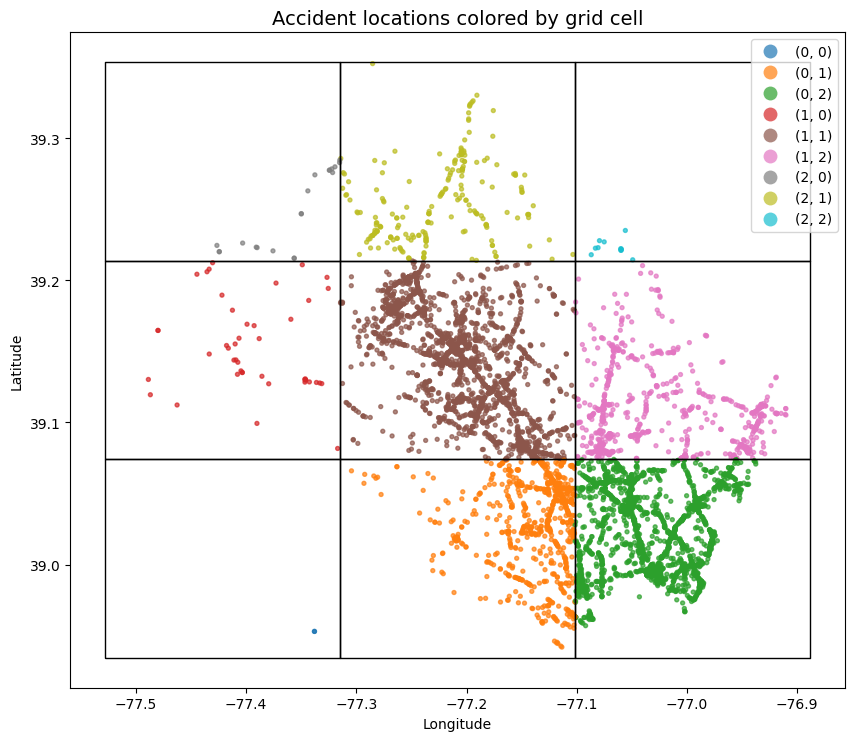

In [39]:
from shapely.geometry import Point
from shapely.geometry import Polygon


lat_min = 38.934343
lat_max = 39.353502
lon_min = -77.52768
lon_max = -76.888505
# Create geometry column from Latitude / Longitude
geometry = [
    Point(lon, lat)
    for lon, lat in zip(
        car_accidents_data['Longitude'],
        car_accidents_data['Latitude']
    )
]

gdf = gpd.GeoDataFrame(
    car_accidents_data,
    geometry=geometry,
    crs="EPSG:4326"
)

polygons = []
cells = []

for (i, j), (lat_min, lat_max, lon_min, lon_max) in grid.items():
    poly = Polygon([
        (lon_min, lat_min),
        (lon_max, lat_min),
        (lon_max, lat_max),
        (lon_min, lat_max)
    ])
    polygons.append(poly)
    cells.append(f"({i}, {j})")

grid_gdf = gpd.GeoDataFrame(
    {'grid_cell': cells},
    geometry=polygons,
    crs="EPSG:4326"
)

gdf['grid_cell_str'] = gdf['grid_cell'].astype(str)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot grid boundaries
grid_gdf.boundary.plot(
    ax=ax,
    color='black',
    linewidth=1
)

# Plot accident points colored by grid cell
gdf.plot(
    ax=ax,
    column='grid_cell_str',
    cmap='tab10',
    markersize=8,
    legend=True,
    alpha=0.7
)

ax.set_title("Accident locations colored by grid cell", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


### API calls
The function below, `month_weather_api`, is used to perform the API requests needed to compute average weather conditions.

We chose to work with **daily variables** in order to compute monthly average weather data. This approach ensures that days with weather conditions significantly different from seasonal norms are properly captured by the daily aggregates. Using hourly data would be overly granular, leading to a large number of API calls and increasing the risk of over-interpreting short-term fluctuations.

In a first step, we perform all the API calls and store the retrieved data in a file within the repository. This avoids having to repeat the entire set of API calls each time the kernel is restarted.

The main differences compared to the previous `weather_api` function are:

- `end_date` is different from `start_date`: each API call retrieves data for all days within a given month.
- Only **daily variables** are requested, and we store all available daily variables, namely:
  - `temperature_2m_min`
  - `temperature_2m_max`
  - `temperature_2m_mean`
  - `weather_code`
  - `apparent_temperature_max`
  - `apparent_temperature_min`
  - `precipitation_sum`
  - `rain_sum`
  - `snowfall_sum`
  - `precipitation_hours`
  - `sunrise`
  - `sunset`
  - `sunshine_duration`
  - `daylight_duration`
  - `wind_speed_10m_max`
  - `wind_gusts_10m_max`
  - `wind_direction_10m_dominant`
  - `shortwave_radiation_sum`
  - `et0_fao_evapotranspiration`

In [40]:
from retry_requests import retry
from datetime import datetime, timezone, timedelta

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

#creer un tableau ca

def month_weather_api(latitude, longitude, start_date, end_date):
# on fournit la lat et long du centre du carré, et la date, afin d'obtenir.

# The order of variables in hourly or daily is important (to assign them correctly below)

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "timezone": "UTC-5",
        "daily": [
        "temperature_2m_min",
        "temperature_2m_max",
        "temperature_2m_mean",
        "weather_code",
        "apparent_temperature_max",
        "apparent_temperature_min",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "precipitation_hours",
        "sunrise",
        "sunset",
        "sunshine_duration",
        "daylight_duration",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ]
    }

    responses = openmeteo.weather_api(weather_api_url, params=params)
    #print(responses)

    response = responses[0]
    # Process daily data. The order of variables needs to be the same as requested.
    
    daily = response.Daily()
    #print(daily)

    daily_min_temp= daily.Variables(0).ValuesAsNumpy()
    daily_max_temp = daily.Variables(1).ValuesAsNumpy()
    daily_mean_temp = daily.Variables(2).ValuesAsNumpy()
    weather_code = daily.Variables(3).ValuesAsNumpy()
    apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
    apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
    precipitation_sum = daily.Variables(6).ValuesAsNumpy()
    rain_sum = daily.Variables(7).ValuesAsNumpy()
    snowfall_sum = daily.Variables(8).ValuesAsNumpy()
    precipitation_hours = daily.Variables(9).ValuesAsNumpy()
    sunrise = daily.Variables(10).ValuesInt64AsNumpy()
    sunset = daily.Variables(11).ValuesInt64AsNumpy()

    ## Or, if we prefer to have the data in a more explicit format:
    # (but we prefered to keep the previous format, expressed as the number of seconds elapsed since January 1, 1970)

    #raw_sunrise = daily.Variables(10).ValuesInt64AsNumpy()
    #raw_sunset = daily.Variables(11).ValuesInt64AsNumpy()

    #list_sunrise = raw_sunrise.tolist()
    #list_sunset = raw_sunset.tolist()

    #utc_minus_5 = timezone(timedelta(hours=-5))

    #sunrise = [datetime.fromtimestamp(e,tz=utc_minus_5).isoformat() for e in list_sunrise]
    
    #sunset = [datetime.fromtimestamp(e, tz=utc_minus_5).isoformat() for e in list_sunset]
    
    sunshine_duration = daily.Variables(12).ValuesAsNumpy()
    daylight_duration = daily.Variables(13).ValuesAsNumpy()
    wind_speed_10m_max = daily.Variables(14).ValuesAsNumpy()
    wind_gusts_10m_max = daily.Variables(15).ValuesAsNumpy()
    wind_direction_10m_dominant = daily.Variables(16).ValuesAsNumpy()
    shortwave_radiation_sum = daily.Variables(17).ValuesAsNumpy()
    et0_fao_evapotranspiration = daily.Variables(18).ValuesAsNumpy()

    daily_data = {"date": pd.date_range(
        start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
        end =  pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = daily.Interval()),
        inclusive = "left"
    )}

    daily_data["temperature_2m_min"] = daily_min_temp
    daily_data["temperature_2m_max"] = daily_max_temp
    daily_data["temperature_2m_mean"] = daily_mean_temp
    daily_data["weather_code"] = weather_code
    daily_data["apparent_temperature_max"] = apparent_temperature_max
    daily_data["apparent_temperature_min"] = apparent_temperature_min
    daily_data["precipitation_sum"] = precipitation_sum
    daily_data["rain_sum"] = rain_sum
    daily_data["snowfall_sum"] = snowfall_sum
    daily_data["precipitation_hours"] = precipitation_hours
    daily_data["sunrise"] = sunrise
    daily_data["sunset"] = sunset
    daily_data["sunshine_duration"] = sunshine_duration
    daily_data["daylight_duration"] = daylight_duration
    daily_data["wind_speed_10m_max"] = wind_speed_10m_max
    daily_data["wind_gusts_10m_max"] = wind_gusts_10m_max
    daily_data["wind_direction_10m_dominant"] = wind_direction_10m_dominant
    daily_data["shortwave_radiation_sum"] = shortwave_radiation_sum
    daily_data["et0_fao_evapotranspiration"] = et0_fao_evapotranspiration

    return {"daily": daily_data}

#month_weather_api(39.2903848, -76.6121893, "2025-01-01", "2025-01-02")
#add_weather()


## pour le rapport:
# convertion du format iso8601 vers un autre pour le sunset et sunrise
# mise sous forme d'un dictonnaire de dictionnaires (un pour les hourly, un pour les daily (ici besoin que du daily, mais dans la fonction plus bas d'ajout de la météo au dataset on utilise les 2 types de données: hourly et daily))
# pas de vérification qu'on a pas de NaN dans l'appel car tous les problèmes ont été réglés à la main donc il n'y en a plus, mais ça pourrait être bien.

### Using the `month_weather_api` function to fill the array

Similarly to Section II.3, to avoid losing the results of API calls in the event of a disruption (due to API failure or any other issue), we save the dataframe as an `.npz` file at the end of each yearly loop for a given month. The `.npz` format is used because the data are stored as arrays.

The intermediate file is saved as `demo_raw_data_weather.npz` (`demo_` is used to avoid overwriting the final output of this function, which we provide in the file `raw_data_weather.npz`).

Due to API rate limits, we also introduce a 60-second pause at the end of each yearly loop.

> ⚠️ **Warning — Long Execution Time**
>
> ⏱️ As a result, this function may take **up to one hour** to complete.  
> If you wish to rerun all the API calls to regenerate the dataset, please uncomment this section.
>
> 💡 **Tip:** We provide the final output of these API calls in the file `raw_data_weather.npz`.

In [41]:
cells = list(grid.keys())

nb_cells_col = (cells[-1])[1]+1 #pour calculer l'index des cellules

months_nb = 12
years = list(range(2014, 2026))
years_nb = len(years)

nb_variables = 19 #the number of variables that we stock for the monthly dataset

#### This section should not be rerun to avoid long execution times (API calls used to retrieve the raw data)

In [42]:
"""
raw_data = np.zeros(
    (len(cells), months_nb, years_nb, nb_variables),
    dtype=list
)

for c in grid :
    cell_index = c[0]*nb_cells_col + c[1]
    # on calcule le centre de la cellule (lat, long)
    cell = grid[c]
    l1, l2, L1, L2 = cell [0], cell[1], cell[2], cell[3]
    lcenter, Lcenter = (l2 + l1)/2, (L2 + L1)/2
    print("Starting cell:", c)
    print("Central latitude:", lcenter)
    print("Central longitude:", Lcenter)

    for m in range(months_nb) :
        m_arg = str(m + 1)
        if m+1 < 10:
            m_arg = "0" + m_arg

        for y in years:
            # Step 1: setting all the parameters to process the corresponding API call

            y_index = 2025 - y #we obtain the index number, starting at 0 for 2025
            #print(y)
            #y_arg = str(y)[2] + str(y)[3]
            #print(y_arg)

            last_day = calendar.monthrange(y, m+1)[1] #+1 because month must be between 1 and 12 for the monthrange
            #print(last_day)

            start_date = str(y) + "-" + m_arg + "-" + "01"

            end_date = str(y) + "-" + m_arg + "-"  + str(last_day)
            
            if y == 2025 and m == 11 :
                end_date = "2025-12-19" #the historcal API only allow past data
        
            print(start_date)
            print(end_date)

            # etape 1: recuperer données brutes via la fonction
            raw_variables = month_weather_api(lcenter, Lcenter, start_date, end_date)
            
            daily_data = raw_variables["daily"]

            # Step 2: convert the arrays into lists using `.tolist()`

            min_temp_list = daily_data['temperature_2m_min'].tolist()
            max_temp_list = daily_data['temperature_2m_max'].tolist()
            mean_temp_list = daily_data['temperature_2m_mean'].tolist()
                    
            weather_code_list = daily_data['weather_code'].tolist()

            apparent_temperature_max_list = daily_data['apparent_temperature_max'].tolist()
            apparent_temperature_min_list = daily_data['apparent_temperature_min'].tolist()

            precipitation_sum_list = daily_data['precipitation_sum'].tolist()
            rain_sum_list = daily_data['rain_sum'].tolist()
            snowfall_sum_list = daily_data['snowfall_sum'].tolist()

            precipitation_hours_list = daily_data['precipitation_hours'].tolist()

            sunrise_list = daily_data['sunrise'].tolist()
            sunset_list = daily_data['sunset'].tolist()
            
            sunshine_duration_list = daily_data['sunshine_duration'].tolist()
            daylight_duration_list = daily_data['daylight_duration'].tolist()

            wind_speed_10m_max_list = daily_data['wind_speed_10m_max'].tolist()
            wind_gusts_10m_max_list = daily_data['wind_gusts_10m_max'].tolist()
            wind_direction_10m_dominant_list = daily_data['wind_direction_10m_dominant'].tolist()

            shortwave_radiation_sum_list = daily_data['shortwave_radiation_sum'].tolist()
            et0_fao_evapotranspiration_list = daily_data['et0_fao_evapotranspiration'].tolist()

            raw_data[cell_index][m][y_index][0] = min_temp_list
            raw_data[cell_index][m][y_index][1] = max_temp_list
            raw_data[cell_index][m][y_index][2] = mean_temp_list

            raw_data[cell_index][m][y_index][3] = weather_code_list

            raw_data[cell_index][m][y_index][4] = apparent_temperature_max_list
            raw_data[cell_index][m][y_index][5] = apparent_temperature_min_list

            raw_data[cell_index][m][y_index][6] = precipitation_sum_list
            raw_data[cell_index][m][y_index][7] = rain_sum_list
            raw_data[cell_index][m][y_index][8] = snowfall_sum_list

            raw_data[cell_index][m][y_index][9] = precipitation_hours_list

            raw_data[cell_index][m][y_index][10] = sunrise_list
            raw_data[cell_index][m][y_index][11] = sunset_list

            raw_data[cell_index][m][y_index][12] = sunshine_duration_list
            raw_data[cell_index][m][y_index][13] = daylight_duration_list

            raw_data[cell_index][m][y_index][14] = wind_speed_10m_max_list
            raw_data[cell_index][m][y_index][15] = wind_gusts_10m_max_list
            raw_data[cell_index][m][y_index][16] = wind_direction_10m_dominant_list

            raw_data[cell_index][m][y_index][17] = shortwave_radiation_sum_list
            raw_data[cell_index][m][y_index][18] = et0_fao_evapotranspiration_list

            np.savez_compressed("demo_raw_data_weather.npz",  allow_pickle=True, raw_data=raw_data)
            #print(raw_data)

    time.sleep(60)
    print("=========================")

# tableau de dimension 4

# avec un appel API (i.e. de la fonction month_weather_api), on remplit une ligne du tableau (une ligne annee)


#data = np.load("raw_data.npz", allow_pickle=True)
#raw_data = data["raw_data"]
#print(raw_data)
"""

'\nraw_data = np.zeros(\n    (len(cells), months_nb, years_nb, nb_variables),\n    dtype=list\n)\n\nfor c in grid :\n    cell_index = c[0]*nb_cells_col + c[1]\n    # on calcule le centre de la cellule (lat, long)\n    cell = grid[c]\n    l1, l2, L1, L2 = cell [0], cell[1], cell[2], cell[3]\n    lcenter, Lcenter = (l2 + l1)/2, (L2 + L1)/2\n    print("Starting cell:", c)\n    print("Central latitude:", lcenter)\n    print("Central longitude:", Lcenter)\n\n    for m in range(months_nb) :\n        m_arg = str(m + 1)\n        if m+1 < 10:\n            m_arg = "0" + m_arg\n\n        for y in years:\n            # Step 1: setting all the parameters to process the corresponding API call\n\n            y_index = 2025 - y #we obtain the index number, starting at 0 for 2025\n            #print(y)\n            #y_arg = str(y)[2] + str(y)[3]\n            #print(y_arg)\n\n            last_day = calendar.monthrange(y, m+1)[1] #+1 because month must be between 1 and 12 for the monthrange\n            

### Correction of the `sunrise` and `sunset` data types (NumPy array → list for consistency)

Initially stored as NumPy arrays, the sunrise and sunset times are ultimately converted to lists—like the other variables—to ensure consistency and to facilitate subsequent operations.

We store the corrected dataset in `full_corrected_raw_data_weather.npz`

In [43]:
from datetime import timezone, timedelta

data = np.load("full_raw_data_weather.npz", allow_pickle=True)

raw_data = data["raw_data"]
utc_minus_5 = timezone(timedelta(hours=-5))

for c in grid :
    cell_index = c[0]*nb_cells_col + c[1]
    # on calcule le centre de la cellule (lat, long)
    cell = grid[c]

    for m in range(months_nb) :

        # pour chacune des variables, on va faire la moyenne des valeurs sur tous les jours du mois, et sur toutes les années
        for y in years:
            y_index = 2025 - y

            list_sunrise = raw_data[cell_index][m][y_index][10].tolist()
            list_sunset = raw_data[cell_index][m][y_index][11].tolist()

            raw_data[cell_index][m][y_index][10] = list_sunrise # ou si conversion souhaitée: [datetime.fromtimestamp(e,tz=utc_minus_5).isoformat() for e in list_sunrise]
            raw_data[cell_index][m][y_index][11] = list_sunset # ou si conversion souhaitée:[datetime.fromtimestamp(e,tz=utc_minus_5).isoformat() for e in list_sunset]

np.savez_compressed("full_corrected_raw_data_weather.npz",  allow_pickle=True, raw_data=raw_data)

### Verification that the correction was successfully applied

data = np.load("full_corrected_raw_data_weather.npz", allow_pickle=True)
raw_data = data["raw_data"]

print(type(raw_data[1][2][5][11]))

<class 'list'>


### Computing the average weather data for each grid square and each month

The average weather values are calculated from the raw data stored in `full_raw_data_weather.npz`.  
This dataset contains daily weather measurements for each grid square, which are then aggregated to compute monthly averages for all variables.

In [44]:
data = np.load("full_corrected_raw_data_weather.npz", allow_pickle=True)
raw_data = data["raw_data"]

# creation of the table for storing average values
# calculation of average values from raw data
### for the variables we are interested in:
## 1. Average over the days of each month
## 2. Average over the years of each month
## we obtain the average values for each month, for each variable, and for each cell in the grid

raw_data_average = np.zeros(
    (len(cells), months_nb, nb_variables),
    dtype=float
)

# calcul des valeurs

for c in grid :
    cell_index = c[0]*nb_cells_col + c[1]
    # on calcule le centre de la cellule (lat, long)
    cell = grid[c]

    for m in range(months_nb):
        m_arg = str(m + 1)
        if m+1 < 10:
            m_arg = "0" + m_arg

        # pour chacune des variables, on va faire la moyenne des valeurs sur tous les jours du mois, et sur toutes les années
        for i in range (0, 19):
            v_acccross_years = []

            for y in years:
                y_index = 2025 - y
                values = raw_data[cell_index][m][y_index][i]

                #if i == 10 or i == 11:
                #    mean = sum(values) / len(values)                            
                #else :
                
                mean = np.mean(raw_data[cell_index][m][y_index][i])

                v_acccross_years.append(mean)
                
            v_mean = np.mean(v_acccross_years)

            raw_data_average[cell_index][m][i] = v_mean
            
np.savez_compressed("full_months_average.npz",  allow_pickle=True, raw_data=raw_data)

### Documentation : Comment utiliser les valeurs moyennes par mois ?

In [45]:
# pour récupérer ce dataset, il suffit de faire :
data = np.load("full_months_average.npz", allow_pickle=True)
raw_data = data["raw_data"]

## et ensuite pour accéder à la valeur moyenne de la variable i du mois m de la case c:
raw_data_average[cell_index][m][i] = v_mean

# où m = 0 pour janvier, 11 pour décembre
# où cell_index est calculé avec : cell_index = c[0]*nb_cells_col + c[1] pour c in grid.keys()
# et où :
# i = 0  -> min_temp
# i = 1  -> max_temp
# i = 2  -> mean_temp
# i = 3  -> weather_code
# i = 4  -> apparent_temperature_max
# i = 5  -> apparent_temperature_min
# i = 6  -> precipitation_sum
# i = 7  -> rain_sum
# i = 8  -> snowfall_sum
# i = 9  -> precipitation_hours
# i = 10 -> sunrise
# i = 11 -> sunset
# i = 12 -> sunshine_duration
# i = 13 -> daylight_duration
# i = 14 -> wind_speed_10m_max
# i = 15 -> wind_gusts_10m_max
# i = 16 -> wind_direction_10m_dominant
# i = 17 -> shortwave_radiation_sum
# i = 18 -> et0_fao_evapotranspiration

### Let's create new variables taking into account the average value we collected

Let $X$ denote a variable obtained from the API calls.
Let $\bar{X}$ denote the average we found using the API calls. 

We introduce the normalized variable $\tilde{X}$, defined by $\tilde{X} = \frac{X - \bar{X}}{\bar{X}}$.


In [46]:
dataset = pd.read_csv("completed_dataset_sample.csv").copy()

grid = create_squares(
    dataset,
    "Latitude",
    "Longitude",
    3,
    3
)

dataset['grid_cell'] = dataset.apply(
    lambda row: find_square_from_grid(
        row['Latitude'],
        row['Longitude'],
        grid
    ),
    axis=1
)
print(grid.keys())
dataset[['Latitude', 'Longitude', 'grid_cell']].head()
dataset = dataset[dataset['grid_cell'].notna()]


dict_keys([(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)])


In [47]:
c=(0,1)
cell_index = c[0]*nb_cells_col + c[1]

print(cell_index)
print(raw_data_average[cell_index][7][2])

1
23.9908642461223


In [48]:
# ================================
# 1. Conversion de la date en datetime
# ================================
dataset['Crash Date/Time'] = pd.to_datetime(dataset['Crash Date/Time'], errors='coerce')


API_Columns = [
    ("temperature", 2),
    ("precipitation", 6),
    ("snowfall", 8),("wind_speed",14)
]

for column_name, var_idx in API_Columns:
    var_name = f"{column_name}_normalized"
    dataset[var_name] = np.nan  # initialiser avec NaN
    
    for index, row in dataset.iterrows():
        month_idx = row['Crash Date/Time'].month - 1
        i, j = row['grid_cell']
        cell_index = i * nb_cells_col + j
        
        # Valeur moyenne provenant de raw_data_average
        mean = raw_data_average[cell_index][month_idx][var_idx]
        
        # Valeur locale et normalisée
        local_value = row[column_name]
        local_value_normalized = (local_value - mean) / mean
        
        # Affecter uniquement à la ligne actuelle
        dataset.at[index, var_name] = local_value_normalized

dataset.head()



/tmp/ipykernel_13983/4079271261.py:27: RuntimeWarning: invalid value encountered in scalar divide
  local_value_normalized = (local_value - mean) / mean


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,soil_temperature,soil_moisture,sunrise,sunset,day_or_night_code,grid_cell,temperature_normalized,precipitation_normalized,snowfall_normalized,wind_speed_normalized
0,MCP3130004M,220015468,Montgomery County Police,Property Damage Crash,2022-04-12 07:40:00,Maryland (State),GEORGIA AVE,CONNECTICUT AVE,NaN,NaN,...,11.233001,0.459,05:35:00,18:42:00,0,"(1, 2)",0.118357,-0.910037,-1.0,-0.427309
1,MCP29520027,16031710,Montgomery County Police,Injury Crash,2016-06-23 10:35:00,Interstate (State),CAPITAL BELTWAY,GEORGIA AVE,NaN,NaN,...,21.872499,0.518,04:43:00,19:37:00,0,"(0, 2)",-0.056369,-0.246665,NaN,-0.719103
2,MCP1048001D,16011658,MONTGOMERY,Property Damage Crash,2016-03-09 07:00:00,Maryland (State),FALLS RD,DEMOCRACY BLVD,NaN,NaN,...,8.493999,0.439,06:28:00,18:09:00,0,"(0, 1)",0.100674,-1.000000,-1.0,-0.685417
3,MCP2667004Q,180023612,Montgomery County Police,Injury Crash,2018-05-14 06:55:00,County,MUNCASTER RD,WILD FLOWER CT,NaN,NaN,...,15.491500,0.407,04:55:00,19:13:00,0,"(1, 1)",-0.155897,-1.000000,NaN,-0.790605
4,MCP3030003D,200018469,Montgomery County Police,Property Damage Crash,2020-05-06 15:02:00,Maryland (State),RIVER RD,SEVEN LOCKS RD,NaN,NaN,...,12.625000,0.506,05:04:00,19:06:00,0,"(0, 1)",-0.326378,-0.654724,NaN,-0.209879


ajout de la version où la moyenne est la moyenne annuelle 

In [49]:
# ================================
# 1. Conversion de la date en datetime
# ================================
dataset['Crash Date/Time'] = pd.to_datetime(dataset['Crash Date/Time'], errors='coerce')

API_Columns = [
    ("temperature", 2),
    ("precipitation", 6),
    ("snowfall", 8),("wind_speed",14)
]

annual_average = {}  

for column_name, var_idx in API_Columns:
    var_name = f"{column_name}_normalized_year"
    var_name_abs = f"{column_name}_normalized_year_abs"

    dataset[var_name] = np.nan  # initialiser la colonne
    dataset[var_name_abs] = np.nan

    # Calculer la moyenne annuelle par cellule, stockée par cell_index
    annual_average[column_name] = {}  # dictionnaire : key=cell_index, value=moyenne annuelle
    for c in grid:
        i_cell, j_cell = c
        cell_index = i_cell * nb_cells_col + j_cell
        monthly_values = [raw_data_average[cell_index][month][var_idx] for month in range(12)]
        mean_annual = np.mean(monthly_values)

        annual_average[column_name][cell_index] = mean_annual

# Vérifions le dictionnaire
print(annual_average)

# Normalisation des valeurs dans le dataset
for column_name, var_idx in API_Columns:
    var_name = f"{column_name}_normalized_year"
    var_name_abs = f"{column_name}_normalized_year_abs"

    for index, row in dataset.iterrows():
        i, j = row['grid_cell']
        cell_index = i * nb_cells_col + j

        local_value = row[column_name]
        mean_annual = annual_average[column_name].get(cell_index, np.nan)  # sécuriser
        
        # Normalisation par rapport à la moyenne annuelle
        local_value_normalized = (local_value - mean_annual)/mean_annual 
        dataset.at[index, var_name] = local_value_normalized
        dataset.at[index, var_name_abs] = abs(local_value_normalized)

dataset.head()


{'temperature': {0: np.float64(13.649465702086333), 1: np.float64(13.544248039343222), 2: np.float64(13.609548994006772), 3: np.float64(13.292457370993667), 4: np.float64(13.138453463261042), 5: np.float64(12.997028153088914), 6: np.float64(13.092095491711639), 7: np.float64(12.432053887904445), 8: np.float64(12.754560413068821)}, 'precipitation': {0: np.float64(3.2639154219967152), 1: np.float64(3.6031785539885526), 2: np.float64(3.6479081149152637), 3: np.float64(3.3218031366655736), 4: np.float64(3.387201092684973), 5: np.float64(3.6767922672748408), 6: np.float64(3.212758184032244), 7: np.float64(3.472699606235403), 8: np.float64(3.5590229083669076)}, 'snowfall': {0: np.float64(0.12003232259971519), 1: np.float64(0.1162235181027131), 2: np.float64(0.11190084103412627), 3: np.float64(0.12610007504187112), 4: np.float64(0.12653295592420896), 5: np.float64(0.12705135028645773), 6: np.float64(0.13113914520088568), 7: np.float64(0.14525565493925052), 8: np.float64(0.13804388020331723)},

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,snowfall_normalized,wind_speed_normalized,temperature_normalized_year,temperature_normalized_year_abs,precipitation_normalized_year,precipitation_normalized_year_abs,snowfall_normalized_year,snowfall_normalized_year_abs,wind_speed_normalized_year,wind_speed_normalized_year_abs
0,MCP3130004M,220015468,Montgomery County Police,Property Damage Crash,2022-04-12 07:40:00,Maryland (State),GEORGIA AVE,CONNECTICUT AVE,NaN,NaN,...,-1.0,-0.427309,0.048932,0.048932,-0.918407,0.918407,-1.0,1.0,-0.336294,0.336294
1,MCP29520027,16031710,Montgomery County Police,Injury Crash,2016-06-23 10:35:00,Interstate (State),CAPITAL BELTWAY,GEORGIA AVE,NaN,NaN,...,NaN,-0.719103,0.596122,0.596122,-0.122785,0.122785,-1.0,1.0,-0.738534,0.738534
2,MCP1048001D,16011658,MONTGOMERY,Property Damage Crash,2016-03-09 07:00:00,Maryland (State),FALLS RD,DEMOCRACY BLVD,NaN,NaN,...,-1.0,-0.685417,-0.431936,0.431936,-1.000000,1.000000,-1.0,1.0,-0.629414,0.629414
3,MCP2667004Q,180023612,Montgomery County Police,Injury Crash,2018-05-14 06:55:00,County,MUNCASTER RD,WILD FLOWER CT,NaN,NaN,...,NaN,-0.790605,0.125817,0.125817,-1.000000,1.000000,-1.0,1.0,-0.797938,0.797938
4,MCP3030003D,200018469,Montgomery County Police,Property Damage Crash,2020-05-06 15:02:00,Maryland (State),RIVER RD,SEVEN LOCKS RD,NaN,NaN,...,NaN,-0.209879,-0.112169,0.112169,-0.583701,0.583701,-1.0,1.0,-0.237028,0.237028


In [50]:
# Mois d'août = 8
mois_cible = 6

# Filtrer le dataset pour le mois d'août
dataset_aout = dataset[dataset['Crash Date/Time'].dt.month == mois_cible].copy()

# Ajouter une colonne pour l'écart à la moyenne annuelle
dataset_aout['temperature_diff_annual'] = dataset_aout.apply(
    lambda row: row['temperature'] - annual_average['temperature'].get(row['grid_cell'][0]*nb_cells_col + row['grid_cell'][1], np.nan),
    axis=1
)

dataset_aout['temperature_diff_annual2'] = dataset_aout.apply(
    lambda row: row['temperature_normalized_year'] if pd.notnull(row['temperature_normalized_year']) else np.nan,
    axis=1
)

# Afficher les premières lignes
print(dataset_aout[['Crash Date/Time', 'grid_cell', 'temperature', 'temperature_diff_annual','temperature_diff_annual2']].head())


       Crash Date/Time grid_cell  temperature  temperature_diff_annual  \
1  2016-06-23 10:35:00    (0, 2)    21.722500                 8.112951   
16 2021-06-03 11:01:00    (1, 1)    25.036999                11.898545   
23 2020-06-14 05:42:00    (1, 1)    14.898000                 1.759546   
25 2019-06-23 16:10:00    (0, 2)    29.919500                16.309951   
30 2018-06-12 21:15:00    (0, 2)    19.448000                 5.838451   

    temperature_diff_annual2  
1                   0.596122  
16                  0.905628  
23                  0.133923  
25                  1.198420  
30                  0.428997  


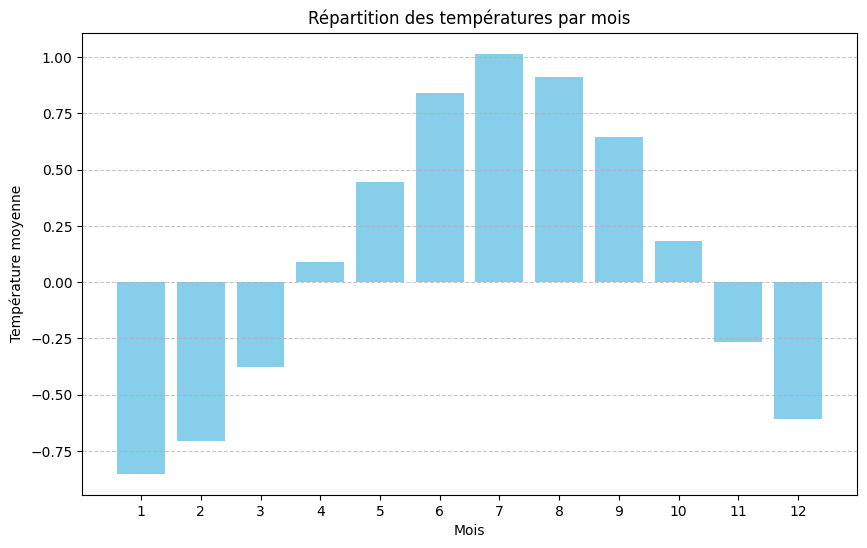

In [51]:
# Extraire le mois de la date
dataset['month'] = dataset['Crash Date/Time'].dt.month

# Calculer la température moyenne par mois
temp_moyenne_par_mois = dataset.groupby('month')['temperature_normalized_year'].mean()

# Diagramme en bâtons
plt.figure(figsize=(10,6))
plt.bar(temp_moyenne_par_mois.index, temp_moyenne_par_mois.values, color='skyblue')
plt.xticks(range(1,13))  # Mois de 1 à 12
plt.xlabel('Mois')
plt.ylabel('Température moyenne')
plt.title('Répartition des températures par mois')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# III. Descriptive Analysis <a id="descriptive"></a>

This section is devoted to descriptive statistical analyses designed to characterize the dataset and explore preliminary relationships between key variables. We begin by constructing categorical variables from selected continuous and nominal features in order to enable stratified analyses and improve interpretability. We then perform an exploratory analysis of the newly added meteorological variables, focusing on their distributions, central tendencies, and variability.

Subsequently, we investigate the association between nighttime conditions and the proportion of drivers involved in substance abuse, using summary statistics and comparative measures. We also examine the relationship between traffic accidents and standardized weather codes, followed by a spatial analysis in which accident occurrences are visualized on area maps under multiple conditions. Finally, we analyze injury severity outcomes and assess how accident frequencies vary across different meteorological conditions, providing an initial descriptive foundation for subsequent inferential modeling.

In [52]:
### Nom des database que nous allons utiliser 

# Database avec 100 000 lignes sans météo -> bigbase_final
# Database avec météo mais sample -> 

## III.1 Construction of Categorical Variables <a id="categorical"></a>


We create new categorical variables derived from the textual variables Driver_Under_Influence and Injury Severity in order to facilitate descriptive statistical analyses and support subsequent predictive modeling. This transformation allows for clearer interpretation and more efficient use of these variables in both exploratory and inferential frameworks.

### Case of substance consumption 

In [53]:


if os.path.exists("completed_dataset_sample.csv"):
    car_accidents_data = pd.read_csv("completed_dataset_sample.csv") # usecols=usecols) to select specific columns
else:
    print("completed_dataset_sample.csv file not found.")


import pandas as pd
import numpy as np

# here we call the million line dataset 
big_dataset=pd.read_csv("Crash_Reporting_-_Drivers_Data.csv").copy()

/tmp/ipykernel_13983/3661937335.py:11: DtypeWarning: Columns (1,9) have mixed types. Specify dtype option on import or set low_memory=False.
  big_dataset=pd.read_csv("Crash_Reporting_-_Drivers_Data.csv").copy()


In [54]:
## V1: AVEC LE SAMPLE

# variable driver_substance_abuse has 3 categories: 0 (No), 1 (Yes), 2 (Unknown)

# adding a column to the dataset indicating whether the driver was under the influence or not

under_influence_modalities = [
    "ALCOHOL PRESENT",
    "ALCOHOL CONTRIBUTED",
    "ILLEGAL DRUG PRESENT",
    "ILLEGAL DRUG CONTRIBUTED",
    "Suspect of Alcohol Use, Not Suspect of Drug Use",
    "Suspect of Alcohol Use, Unknown",
    "Suspect of Alcohol Use, Suspect of Drug Use",
    "COMBINED SUBSTANCE PRESENT",
    "MEDICATION CONTRIBUTED",
    "MEDICATION PRESENT",
]

# We apply this to the two types of datasets : 
car_accidents_data["Driver_Under_Influence"] = car_accidents_data["Driver Substance Abuse"].apply(
    lambda x: 1 if x in under_influence_modalities else 0
)


bigbase_final["Driver_Under_Influence"] = bigbase_final["Driver Substance Abuse"].apply(
    lambda x: 1 if x in under_influence_modalities else 0
)

bigbase_final["Driver_Under_Influence"].value_counts()
car_accidents_data["Driver_Under_Influence"].value_counts()




Driver_Under_Influence
0    6272
1     217
Name: count, dtype: int64

### Case of injury 

In [55]:

# Mapping dictionary
injury_map = {
    'NO APPARENT INJURY': 0,
    'No Apparent Injury': 0,
    'POSSIBLE INJURY': 1,
    'Possible Injury': 1,
    'SUSPECTED MINOR INJURY': 1,
    'Suspected Minor Injury': 1,
    'SUSPECTED SERIOUS INJURY': 2,
    'Suspected Serious Injury': 2,
    'FATAL INJURY': 2,
    'Fatal Injury': 2,
    np.nan: np.nan
}

# We apply this to the two types of datasets : 
dataset['injury_severity_num'] = dataset['Injury Severity'].map(injury_map)
bigbase_final['injury_severity_num'] = bigbase_final['Injury Severity'].map(injury_map)

# Check results
print(dataset[['Injury Severity', 'injury_severity_num']].head(10))


          Injury Severity  injury_severity_num
0      NO APPARENT INJURY                  0.0
1         POSSIBLE INJURY                  1.0
2      NO APPARENT INJURY                  0.0
3         POSSIBLE INJURY                  1.0
4      NO APPARENT INJURY                  0.0
5  SUSPECTED MINOR INJURY                  1.0
6      No Apparent Injury                  0.0
7  Suspected Minor Injury                  1.0
8      No Apparent Injury                  0.0
9      NO APPARENT INJURY                  0.0


 II.1) Repartition of the modalities of variables

In [56]:
car_accidents_data.head()

print(car_accidents_data["weather_code"].value_counts())

weather_code
3.0     2114
0.0     1936
1.0      723
2.0      591
51.0     532
53.0     184
61.0     156
63.0     104
55.0      64
73.0      37
71.0      26
75.0      13
65.0       9
Name: count, dtype: int64


## III.2 Preliminary Analysis of the New Meteorological Variables <a id="weather_analysis"></a>


We examine the distribution of observations for each meteorological variable in the dataset using simple graphical representations.

We first implement functions to generate histograms for the variables of interest.

In [57]:
# The goal here is to get an intuition through a spacial visualation of our weather variables


def plot_numeric_histogram(df, column_name, bins=30, color='skyblue'):
    """
    Displays the histogram of a numerical variable.

    Arguments:
    df : pandas.DataFrame
    column_name : str, name of the numerical column
    bins : int, number of bins for the histogram (default: 30)
    color : str, color of the histogram (default: 'skyblue')
    """
    plt.figure(figsize=(8,5))
    plt.hist(df[column_name].dropna(), bins=bins, color=color, edgecolor='black')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column_name}')
    plt.show()


### Case of Temperature

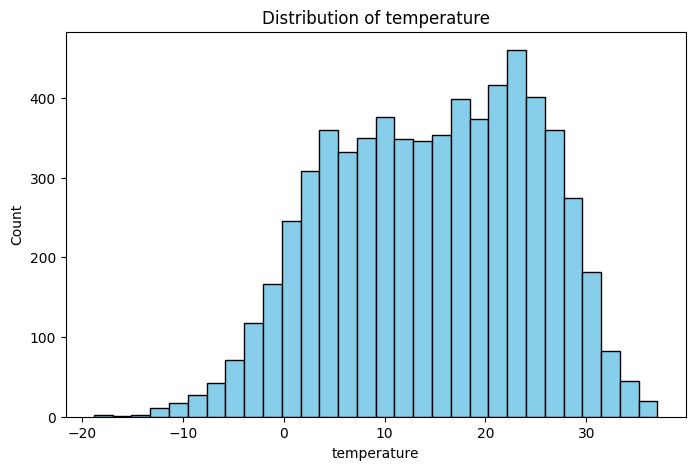

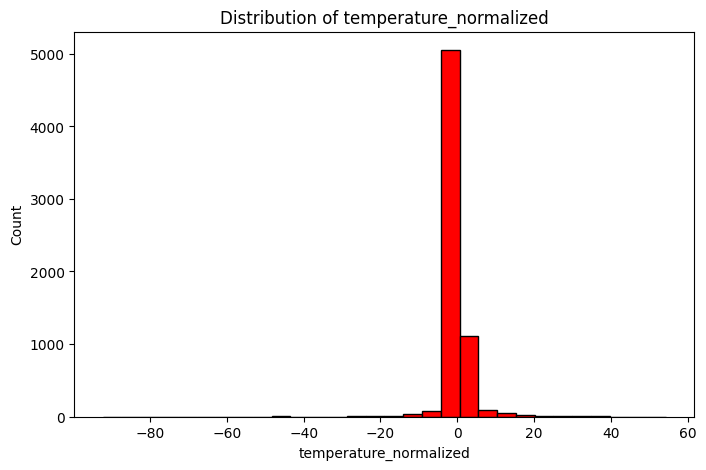

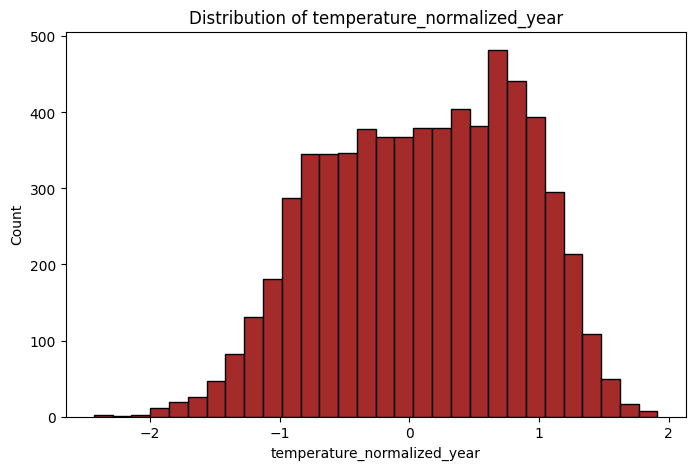

In [58]:
plot_numeric_histogram(dataset, "temperature", bins=30, color='skyblue')
plot_numeric_histogram(dataset, "temperature_normalized", bins=30, color='red')
plot_numeric_histogram(dataset, "temperature_normalized_year", bins=30, color='brown')


For the non-normalized temperature variable, we observe a wide range of values, which is expected since temperatures from all months of the year are considered. The temperature normalized at the annual level exhibits a similar pattern. In contrast, the monthly normalized temperature shows limited deviation from seasonal norms, indicating that few observations correspond to unusually extreme temperatures for a given month.

### Case of precipitation

We observe that most days correspond to low precipitation levels. The normalized version of this variable exhibits a similar distribution.

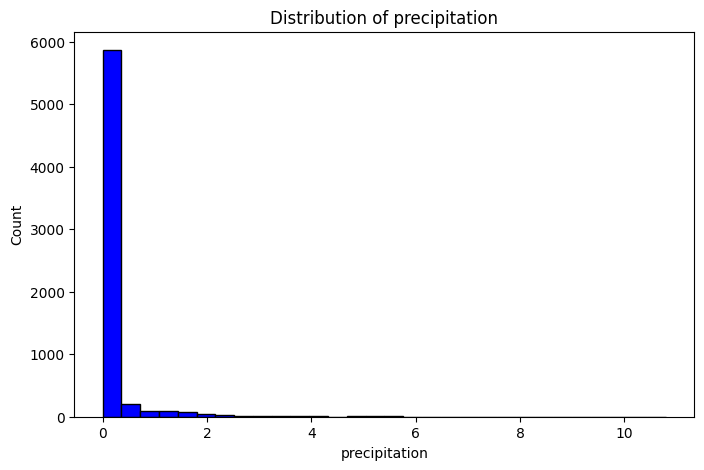

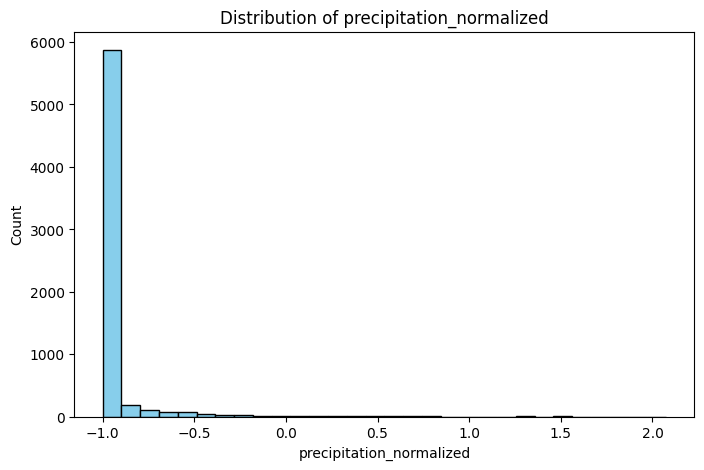

In [59]:
plot_numeric_histogram(dataset, "precipitation", bins=30, color='blue')
plot_numeric_histogram(dataset, "precipitation_normalized", bins=30, color='skyblue')

The distribution of precipitation (measured in millimeters) is highly right-skewed, with the vast majority of observations concentrated near zero, indicating that most car accidents occurs in days that experience little to no rainfall. A small number of days exhibit substantially higher precipitation values, forming a long right tail. The normalized precipitation variable shows a very similar pattern, with most observations taking negative values, reflecting precipitation levels below the annual average. Overall, both representations confirm that heavy rainfall events are relatively rare in the dataset, while low-precipitation conditions dominate.

### Case of snowfall

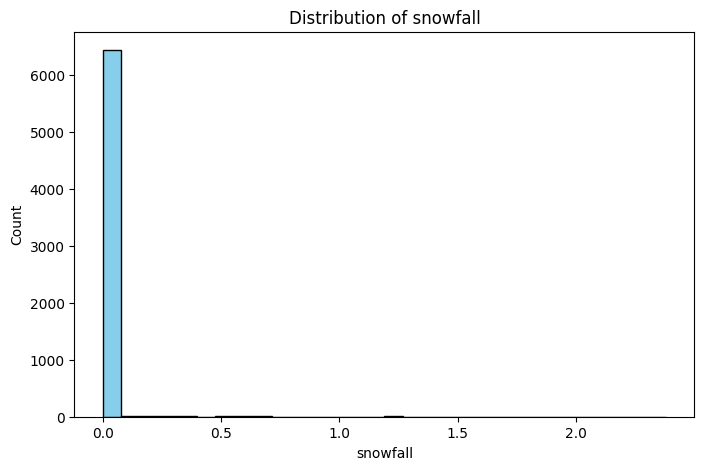

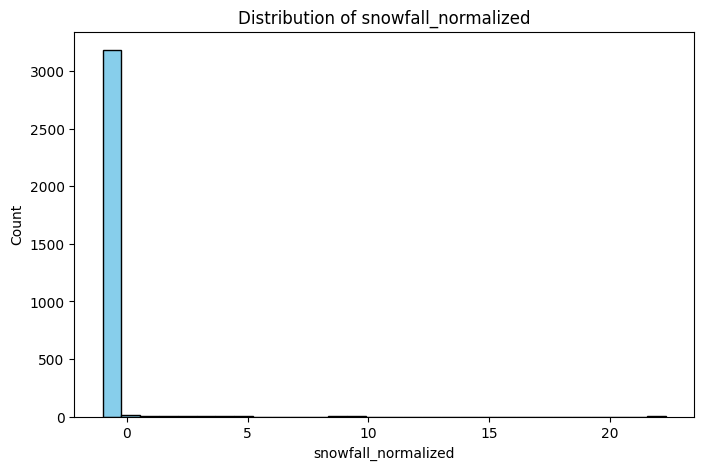

In [60]:
plot_numeric_histogram(dataset, "snowfall", bins=30, color='skyblue')
plot_numeric_histogram(dataset, "snowfall_normalized", bins=30, color='skyblue')

We observe that snowfall is extremely rare in Montgomery County; consequently, the snowfall variable will be excluded from the analysis.

### Case of wind speed

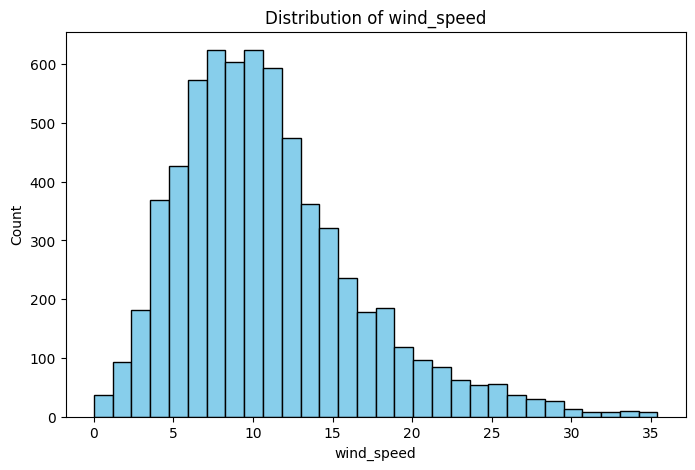

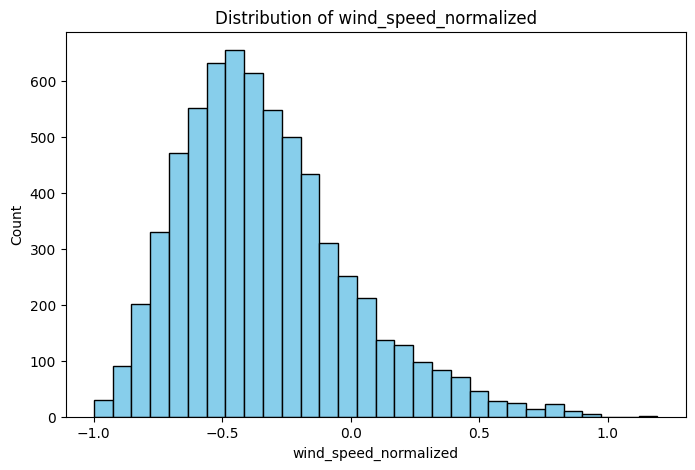

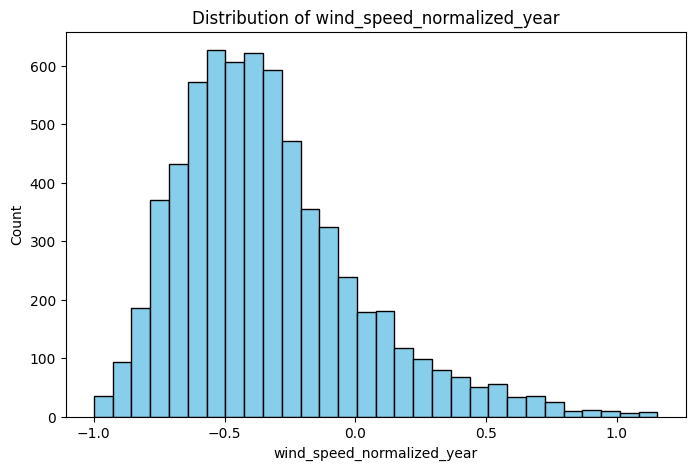

In [61]:
plot_numeric_histogram(dataset, "wind_speed", bins=30, color='skyblue')
plot_numeric_histogram(dataset, "wind_speed_normalized", bins=30, color='skyblue')
plot_numeric_histogram(dataset, "wind_speed_normalized_year", bins=30, color='skyblue')

According to the API documentation, wind speed is measured in kilometers per hour (km/h). The wind_speed variable displays a very similar distribution in both its raw and normalized forms, with the highest concentration of observations around 10 km/h. In the normalized representation, accident occurrences are predominantly associated with negative values (around −0.5), suggesting that a larger number of accidents take place under wind conditions below the annual average. However, this observation is purely descriptive and does not imply a causal relationship. Overall, wind speed appears to exhibit limited variability in relation to accident occurrence, indicating that it may have a relatively weak explanatory role in the context of traffic accidents compared to other factors.

### Weather code 

{Mettre un reminder sur le fonctionnement du Weather code}

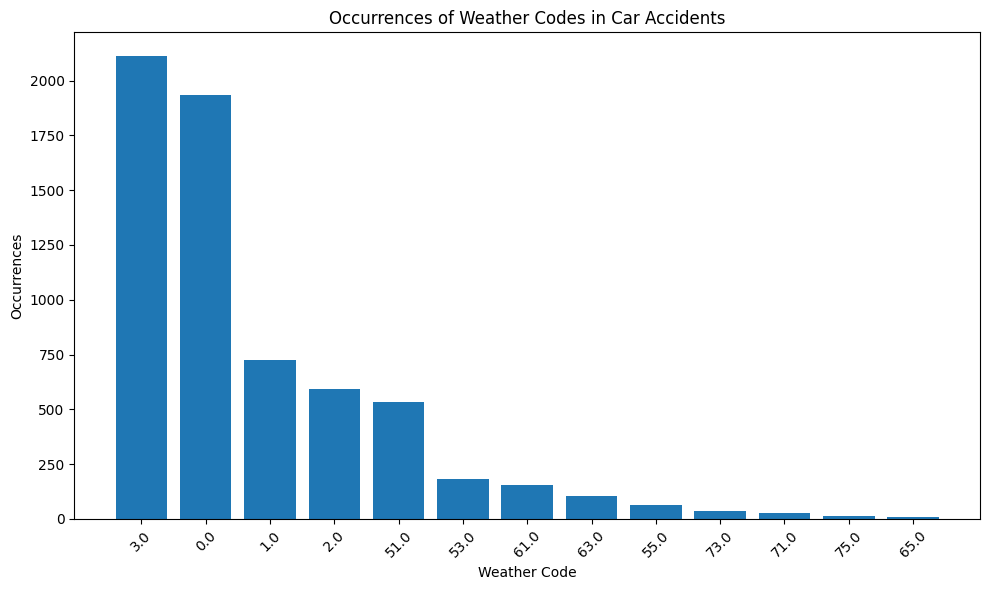

In [62]:
# Plotting the graphs with the proportion of weather_code in Car Accidents
#labels = ["Not Under Influence", "Under Influence"]
# compter les occurrences
counts = car_accidents_data["weather_code"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(counts.index.astype(str), counts.values)  # aucun style/couleur imposé
plt.xlabel("Weather Code")
plt.ylabel("Occurrences")
plt.title("Occurrences of Weather Codes in Car Accidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## III.3 Correlation between night and the percentage of accident with Driver Substance Abuse <a id="drogue"></a>


In [63]:
car_accidents_data.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Name',
       'Off-Road Description', 'Municipality', 'Related Non-Motorist',
       'Collision Type', 'Weather', 'Surface Condition', 'Light',
       'Traffic Control', 'Driver Substance Abuse',
       'Non-Motorist Substance Abuse', 'Person ID', 'Driver At Fault',
       'Injury Severity', 'Circumstance', 'Driver Distracted By',
       'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent',
       'Vehicle First Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Going Dir', 'Speed Limit',
       'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year', 'Vehicle Make',
       'Vehicle Model', 'Latitude', 'Longitude', 'Location', 'temperature',
       'apparent_temperature', 'humidity', 'weather_code', 'precipitation',
       'snowfall', 'wind_speed', 'wind_direction', 'soil_temperature',
       'soil_moisture',

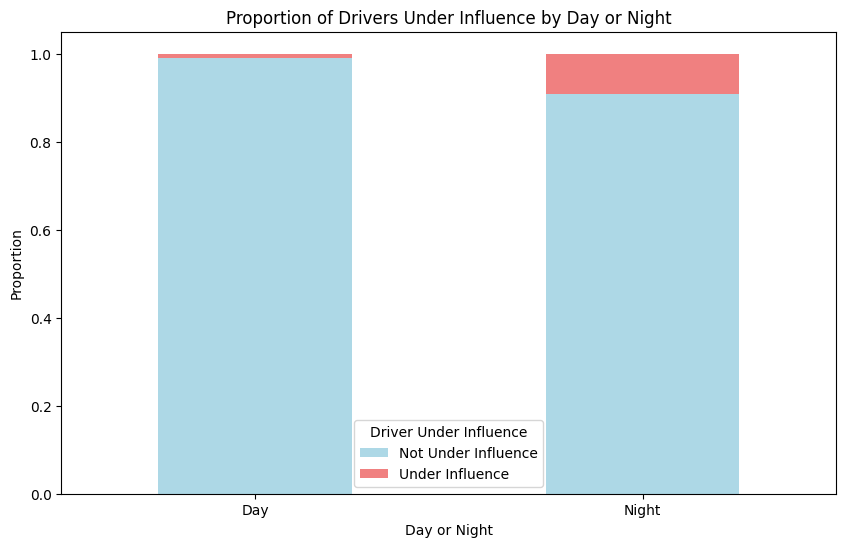

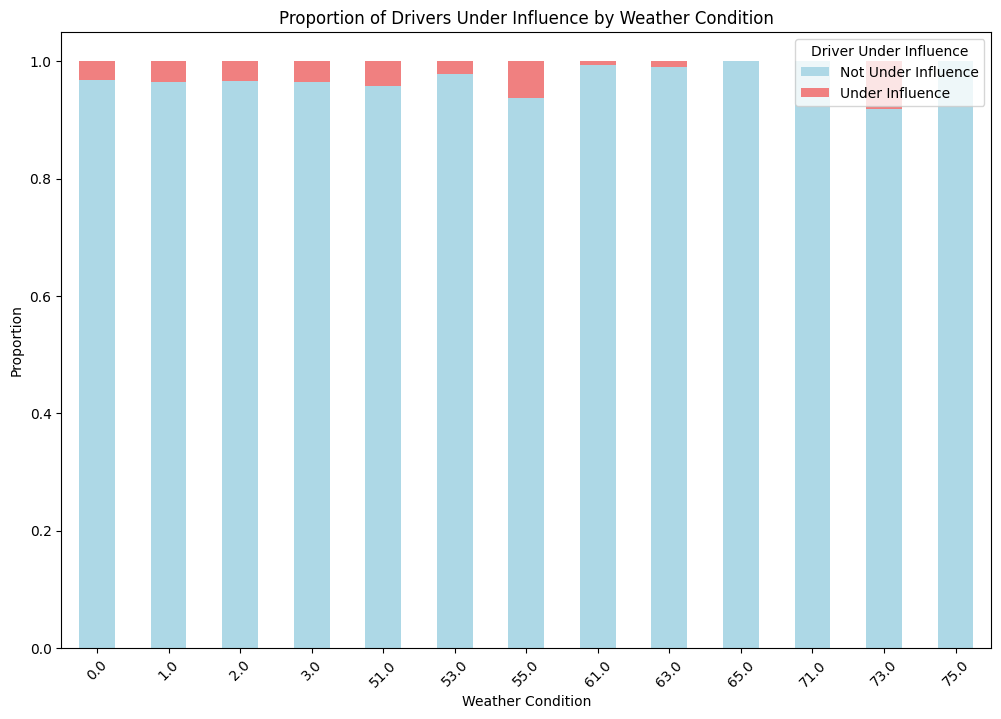

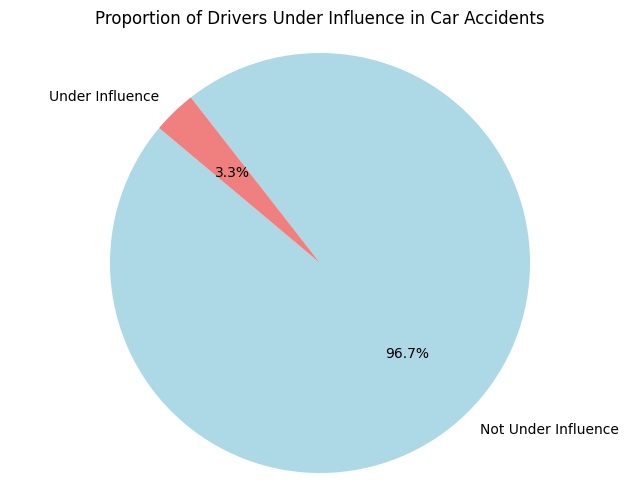

In [64]:
## V1: AVEC LE SAMPLE


# percentage of accident where the driver was under the influence during the night vs day
day_night_influence = pd.crosstab(
    car_accidents_data["day_or_night_code"],
    car_accidents_data["Driver_Under_Influence"],
    rownames=["Day or Night"],
    colnames=["Driver Under Influence"],
    normalize='index'
)

day_night_influence.plot(kind='bar', stacked=True, figsize=(10, 6), color=['lightblue', 'lightcoral'])
plt.title("Proportion of Drivers Under Influence by Day or Night")
plt.ylabel("Proportion")
plt.xticks(ticks=[0, 1], labels=["Day", "Night"], rotation=0)
plt.legend(title="Driver Under Influence", labels=["Not Under Influence", "Under Influence"])
plt.show()


# percentage of accident where the driver was under the influence during different weather conditions
weather_influence = pd.crosstab(
    car_accidents_data["weather_code"],
    car_accidents_data["Driver_Under_Influence"],
    rownames=["Weather Condition"],
    colnames=["Driver Under Influence"],
    normalize='index'
)

weather_influence.plot(kind='bar', stacked=True, figsize=(12, 8), color=['lightblue', 'lightcoral'])
plt.title("Proportion of Drivers Under Influence by Weather Condition")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Driver Under Influence", labels=["Not Under Influence", "Under Influence"])
plt.show()

# Plotting the graphs with the proportion of drivers under influence in Car Accidents
labels = ["Not Under Influence", "Under Influence"]
sizes = car_accidents_data["Driver_Under_Influence"].value_counts().values
colors = ['lightblue', 'lightcoral']
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Proportion of Drivers Under Influence in Car Accidents")
plt.axis('equal')
plt.show()

In [65]:
print(big_dataset)

       Report Number Local Case Number Agency Name       ACRS Report Type  \
0        MCP3126006X         250037402  MONTGOMERY           Injury Crash   
1        MCP2349001B         250037516  MONTGOMERY  Property Damage Crash   
2        MCP296500BC         250033157  MONTGOMERY  Property Damage Crash   
3        MCP2159003K         250037509  MONTGOMERY  Property Damage Crash   
4        MCP312900D6         250034573  MONTGOMERY  Property Damage Crash   
...              ...               ...         ...                    ...   
206304    DD5666002H         250037005   ROCKVILLE           Injury Crash   
206305   MCP3257008X         250036805  MONTGOMERY  Property Damage Crash   
206306   MCP2864005C         250036079  MONTGOMERY  Property Damage Crash   
206307   MCP33870035         250036843  MONTGOMERY           Injury Crash   
206308   MCP2987009S         250036613  MONTGOMERY  Property Damage Crash   

               Crash Date/Time              Route Type  \
0       08/21/202

## III.4 Plotting area map with multiple conditions <a id="map"></a>

In this section, we create **three HTML files** containing interactive maps of car accidents:

1. **All Car Accidents**  
   - Displayed as **red points** on the map.

2. **Day vs. Night Accidents**  
   - Accidents are categorized based on whether they occurred during the **day** or at **night**.

3. **Accidents by Weather Conditions**  
   - Accidents are sorted according to the **weather code** corresponding to the hour when they occurred.

> **Note:** To view the interactive maps, open the corresponding HTML file in a browser.

In [66]:
# Extraire la date
car_accidents_data['Date'] = car_accidents_data['Crash Date/Time'].str.split(" ").str[0]

# Convertir l'heure en format 24h
def convert_to_24h(date_time):
    hour = date_time.split(" ")[1].split(":")[0]
    time_of_day = date_time.split(" ")[2]
    time_minutes = date_time.split(" ")[1].split(":")[1]

    if time_of_day == "PM" and hour != "12":
        accident_hour_24h = int(hour) + 12
    elif time_of_day == "AM" and hour == "12":
        accident_hour_24h = 00
    else :
        accident_hour_24h = int(hour)

    if accident_hour_24h < 10:
        accident_hour_24h = "0" + str(accident_hour_24h)

    accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

    return accident_time_24h

car_accidents_data['Accident time in 24h format'] = car_accidents_data['Crash Date/Time'].apply(convert_to_24h)

car_accidents_data[['Crash Date/Time', 'Date', 'Accident time in 24h format', 'Latitude', 'Longitude']].head()

,Crash Date/Time,Date,Accident time in 24h format,Latitude,Longitude
0,04/12/2022 07:40:00 AM,04/12/2022,07:40:00,39.084912,-77.076068
1,06/23/2016 10:35:00 AM,06/23/2016,10:35:00,39.013298,-77.045822
2,03/09/2016 07:00:00 AM,03/09/2016,07:00:00,39.026372,-77.204397
3,05/14/2018 06:55:00 AM,05/14/2018,06:55:00,39.176243,-77.118350
4,05/06/2020 03:02:00 PM,05/06/2020,15:02:00,38.992689,-77.161965


In [67]:
## V2: Avec les 1M de lignes

# Extraire la date
bigbase_final['Date'] = bigbase_final['Crash Date/Time'].str.split(" ").str[0]

# Convertir l'heure en format 24h
def convert_to_24h(date_time):
    hour = date_time.split(" ")[1].split(":")[0]
    time_of_day = date_time.split(" ")[2]
    time_minutes = date_time.split(" ")[1].split(":")[1]

    if time_of_day == "PM" and hour != "12":
        accident_hour_24h = int(hour) + 12
    elif time_of_day == "AM" and hour == "12":
        accident_hour_24h = 00
    else :
        accident_hour_24h = int(hour)

    if accident_hour_24h < 10:
        accident_hour_24h = "0" + str(accident_hour_24h)

    accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

    return accident_time_24h

bigbase_final['Accident time in 24h format'] = bigbase_final['Crash Date/Time'].apply(convert_to_24h)

bigbase_final[['Crash Date/Time', 'Date', 'Accident time in 24h format', 'Latitude', 'Longitude']].head()

,Crash Date/Time,Date,Accident time in 24h format,Latitude,Longitude
0,08/21/2025 05:21:00 PM,08/21/2025,17:21:00,39.219796,-77.257416
2,07/25/2025 11:55:00 AM,07/25/2025,11:55:00,39.121219,-76.988905
3,08/22/2025 10:36:00 AM,08/22/2025,10:36:00,39.207931,-77.141480
5,08/19/2025 09:50:00 AM,08/19/2025,09:50:00,39.092734,-77.076470
6,08/23/2025 11:50:00 AM,08/23/2025,11:50:00,39.058466,-77.121265


In [68]:

# Centre approximatif de la zone (Maryland / Washington DC)
center_lat = car_accidents_data["Latitude"].mean()
center_lon = car_accidents_data["Longitude"].mean()

# Création de la carte
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Ajout des points
for _, row in car_accidents_data.iterrows():
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=3,
        fill=True,
        fill_opacity=0.7,
        opacity=0.7,
        color='red' #if row["Driver_Under_Influence"] == 1 else 'blue',
    ).add_to(m)

# Affichage de la carte
m

#enregistrer la carte sous format html
m.save("car_accidents_map.html")


## Map Screenshot - All car accidents

![Car accidents map - Day vs. Night](Car%20accidents%20map.jpg)

> **Note:** To view the **interactive map**, please open the corresponding HTML file in a browser.

In [69]:
# Extraire la date
car_accidents_data['Date'] = car_accidents_data['Crash Date/Time'].str.split(" ").str[0]

# Convertir l'heure en format 24h
def convert_to_24h(date_time):
    hour = date_time.split(" ")[1].split(":")[0]
    time_of_day = date_time.split(" ")[2]
    time_minutes = date_time.split(" ")[1].split(":")[1]

    if time_of_day == "PM" and hour != "12":
        accident_hour_24h = int(hour) + 12
    elif time_of_day == "AM" and hour == "12":
        accident_hour_24h = 00
    else :
        accident_hour_24h = int(hour)

    if accident_hour_24h < 10:
        accident_hour_24h = "0" + str(accident_hour_24h)

    accident_time_24h = str(accident_hour_24h) + ":" + time_minutes + ":00"

    return accident_time_24h

car_accidents_data['Accident time in 24h format'] = car_accidents_data['Crash Date/Time'].apply(convert_to_24h)

car_accidents_data[['Crash Date/Time', 'Date', 'Accident time in 24h format', 'Latitude', 'Longitude']].head()

,Crash Date/Time,Date,Accident time in 24h format,Latitude,Longitude
0,04/12/2022 07:40:00 AM,04/12/2022,07:40:00,39.084912,-77.076068
1,06/23/2016 10:35:00 AM,06/23/2016,10:35:00,39.013298,-77.045822
2,03/09/2016 07:00:00 AM,03/09/2016,07:00:00,39.026372,-77.204397
3,05/14/2018 06:55:00 AM,05/14/2018,06:55:00,39.176243,-77.118350
4,05/06/2020 03:02:00 PM,05/06/2020,15:02:00,38.992689,-77.161965


### Day VS Night

In [70]:

# Centre approximatif
center_lat = car_accidents_data["Latitude"].mean()
center_lon = car_accidents_data["Longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

for _, row in car_accidents_data.iterrows():
    
    color = 'yellow' if row["day_or_night_code"] == 0 else 'purple'
    label = "Day" if row["day_or_night_code"] == 0 else "Night"
    
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=4,
        fill=True,
        fill_opacity=0.7,
        opacity=0.7,
        color=color,
        tooltip=f"{label}"
    ).add_to(m)

m

m.save("car_accidents_map_day_vs_night.html")

## Map Screenshot - Day (yellow) vs. Night (purple)

![Car accidents map - Day vs. Night](Car%20accidents%20map%20-%20Day%20vs.%20Night.jpg)

> **Note:** To view the **interactive map**, please open the corresponding HTML file in a browser.

### Weather code

To make the map easier to use, we included a **clear description for each weather code** present in the database.

In [71]:

weather_mapping = {
    0.0: ("skyblue", "Clear"),
    1.0: ("blue", "Rain"),
    2.0: ("white", "Snow"),
    3.0: ("gray", "Fog"),
    51.0: ("lightblue", "Drizzle"),
    53.0: ("deepskyblue", "Rain Shower"),
    55.0: ("darkblue", "Heavy Rain"),
    61.0: ("lightgray", "Sleet"),
    63.0: ("silver", "Freezing Rain"),
    65.0: ("darkgray", "Hail"),
    71.0: ("snow", "Snowfall Light"),
    73.0: ("whitesmoke", "Snowfall Moderate"),
    75.0: ("aliceblue", "Snowfall Heavy"),
}

# Centre de la carte
center_lat = car_accidents_data["Latitude"].mean()
center_lon = car_accidents_data["Longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Ajout des points avec couleur selon weather_code
for _, row in car_accidents_data.iterrows():
    color, label = weather_mapping.get(row["weather_code"], ("black", "Unknown"))
    
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=4,
        fill=True,
        fill_opacity=0.7,
        opacity=0.7,
        color=color,
        tooltip=f"Weather: {label}"
    ).add_to(m)

m

#enregistrer la carte sous format html
m.save("car_accidents_map_by_weather.html")

## Map Screenshot - By weather

![Car accidents map - Weather](Car%20accidents%20map%20-%20Weather.jpg)

> **Note:** To view the **interactive map**, please open the corresponding HTML file in a browser.

First let's aquire the dataset, cleaned 

In [72]:
# here we call the million line dataset 
#big_dataset=pd.read_csv("Crash_Reporting_-_Drivers_Data.csv").copy()

# dataset here is the sampled data set with weather data
#dataset=pd.read_csv("completed_dataset_sample.csv").copy()

dataset.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Name',
       'Off-Road Description', 'Municipality', 'Related Non-Motorist',
       'Collision Type', 'Weather', 'Surface Condition', 'Light',
       'Traffic Control', 'Driver Substance Abuse',
       'Non-Motorist Substance Abuse', 'Person ID', 'Driver At Fault',
       'Injury Severity', 'Circumstance', 'Driver Distracted By',
       'Drivers License State', 'Vehicle ID', 'Vehicle Damage Extent',
       'Vehicle First Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Going Dir', 'Speed Limit',
       'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year', 'Vehicle Make',
       'Vehicle Model', 'Latitude', 'Longitude', 'Location', 'temperature',
       'apparent_temperature', 'humidity', 'weather_code', 'precipitation',
       'snowfall', 'wind_speed', 'wind_direction', 'soil_temperature',
       'soil_moisture',

## III.5 Descriptive Analysis of Injury Severity <a id="injury_desc"></a>


### Using Scatter Plots

Scatter plots visualization is particularly useful for exploring the distribution of accident severity across geographic coordinates or meteorological conditions. By plotting individual observations, we can detect areas with higher concentrations of severe accidents or unusual occurrences. The expected outcome is to gain an intuitive understanding of where and under which conditions the most serious accidents tend to occur, providing a visual foundation for more formal statistical modeling.

In [73]:

def plot_scatter(df, x_col, y_col, color='blue', size=30, alpha=0.7):
    """
    Plot a scatter plot between two variables.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset
    x_col : str
        Name of the column for x-axis
    y_col : str
        Name of the column for y-axis
    color : str
        Color of the points (default 'blue')
    size : int
        Size of the points (default 30)
    alpha : float
        Transparency of the points (default 0.7)
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(df[x_col], df[y_col], c=color, s=size, alpha=alpha, edgecolor='k')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Scatter Plot of {y_col} vs {x_col}')
    plt.grid(True)
    plt.show()


In [74]:
dataset['temperature_normalized_year'].min()

np.float64(-2.4321700619254347)

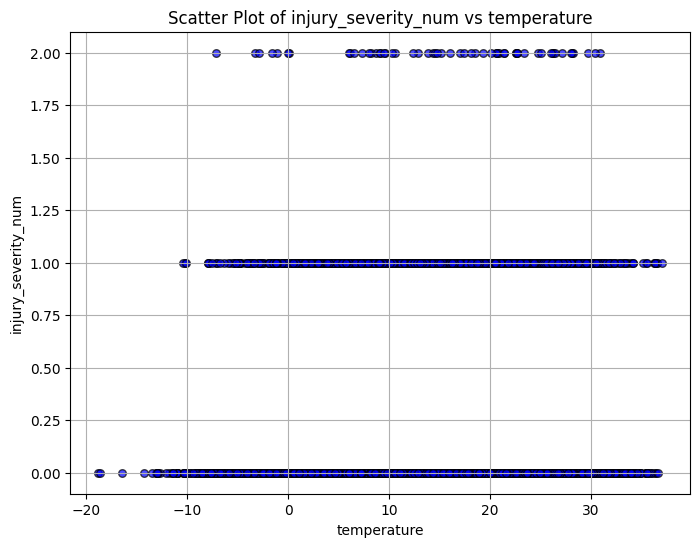

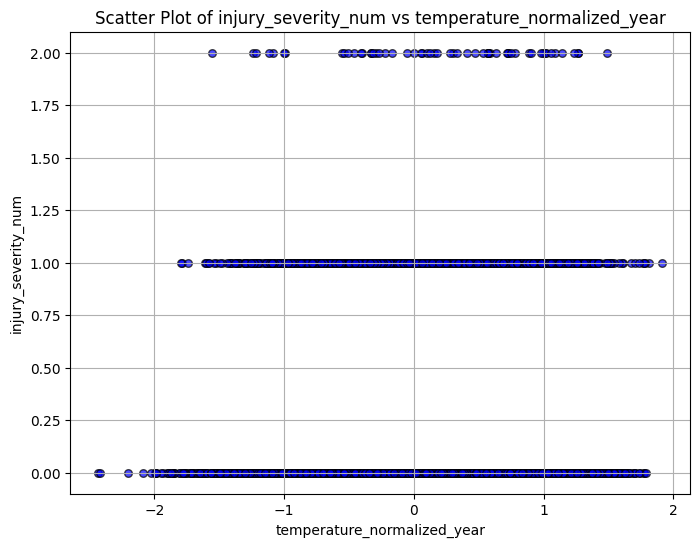

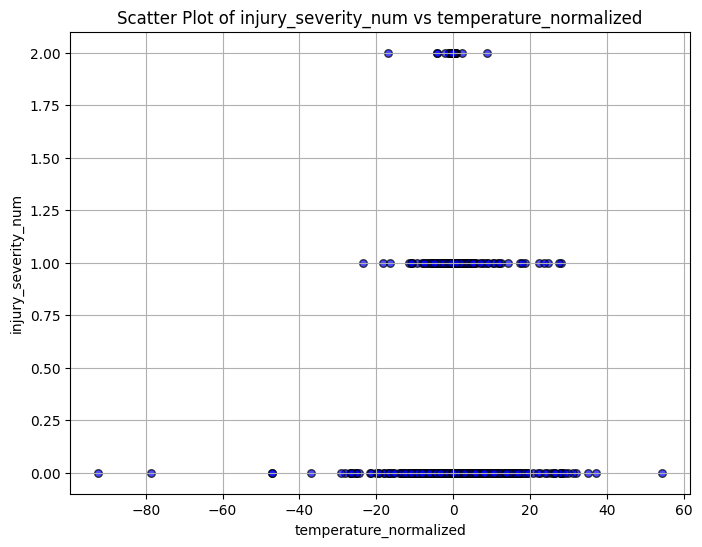

In [75]:

plot_scatter(dataset, 'temperature', 'injury_severity_num')
plot_scatter(dataset, 'temperature_normalized_year', 'injury_severity_num')
plot_scatter(dataset, 'temperature_normalized', 'injury_severity_num')



- Scatter Plot of injury_severity_num vs temperature (°C)

In the first plot, injury_severity_num is plotted against raw temperature values. No strong linear trend is observable; the injury severity seems largely invariant across the observed range of temperatures. The temperature range spans approximately -20°C to 35°C, with most data points concentrated between 0°C and 30°C.

- Scatter Plot of injury_severity_num vs temperature_normalized

- Scatter Plot of injury_severity_num vs temperature_normalized_year

In the third plot, temperature is further normalized on a yearly basis. The range of the normalized temperature is constrained approximately between -2 and 2. The ordinal clustering of injury severity levels persists, with no evident linear trend, which implies that yearly normalization does not substantially alter the observed association between temperature and injury severity. 

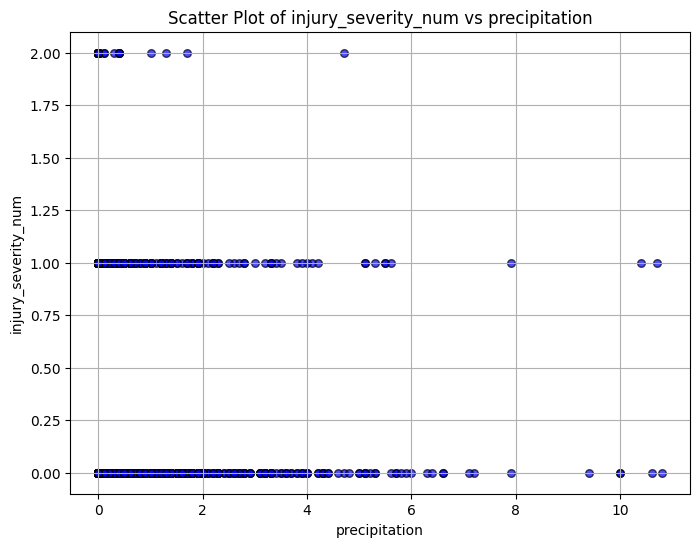

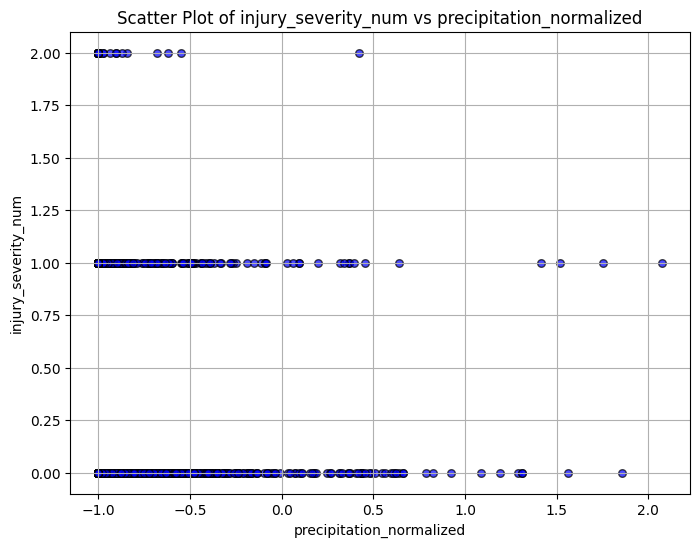

In [76]:

plot_scatter(dataset, 'precipitation', 'injury_severity_num')
plot_scatter(dataset, 'precipitation_normalized', 'injury_severity_num')


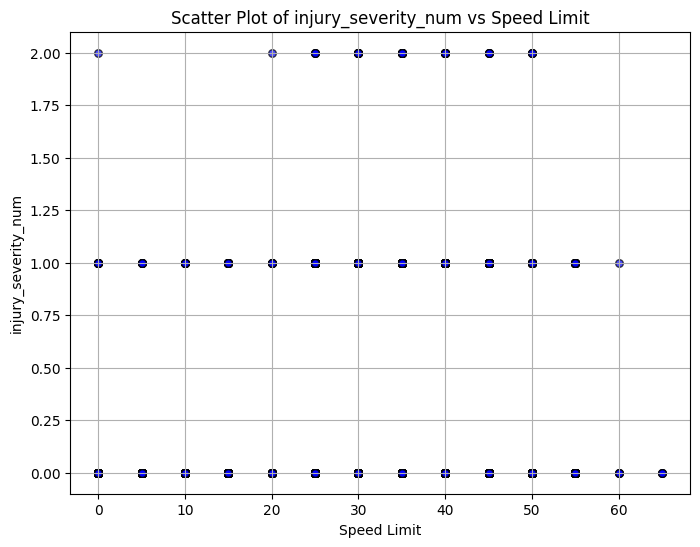

In [77]:

plot_scatter(dataset, 'Speed Limit', 'injury_severity_num')


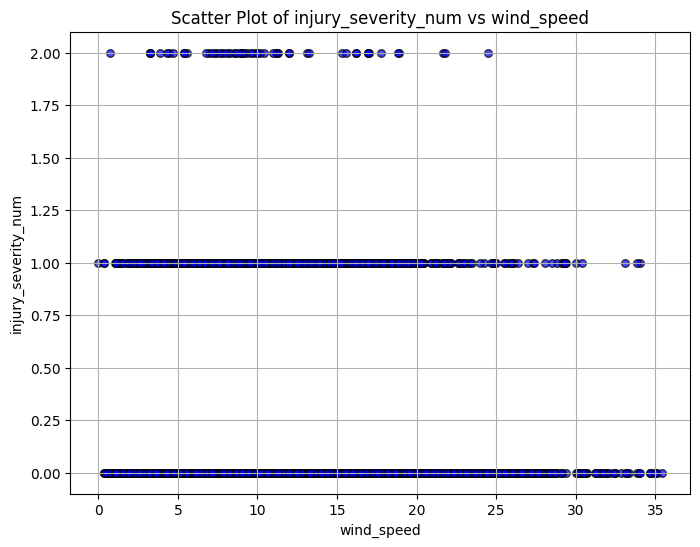

In [78]:
plot_scatter(dataset, 'wind_speed', 'injury_severity_num')


### Analysis Using Grouped Bar Plots

Using grouped bar plots allows us to compare categorical variables across different groups simultaneously. By presenting the counts or proportions side by side, we can quickly identify patterns, disparities, or trends across categories. We expect this method to highlight which conditions are associated with higher frequencies of severe accidents providing a clear visual foundation for subsequent statistical analyses.

In [79]:


def grouped_barplot_proportion(df, numeric_col, category_col, bins=None, bin_labels=None, color_palette=None):
    """
    Plot a stacked bar chart showing proportions of a categorical variable for each numeric bin.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataset
    numeric_col : str
        Numeric variable to bin (e.g., 'Speed Limit')
    category_col : str
        Categorical variable (e.g., 'injury_severity_ord')
    bins : list or int, optional
        Bins for numeric variable (default: no binning)
    bin_labels : list, optional
        Labels for bins (default: generated automatically)
    color_palette : list, optional
        Colors for each category (default matplotlib)
    """
    # Bin numeric variable if bins are provided
    if bins is not None:
        df['numeric_bin'] = pd.cut(df[numeric_col], bins=bins, labels=bin_labels, include_lowest=True)
    else:
        df['numeric_bin'] = df[numeric_col]

    # Pivot table: counts
    pivot = df.pivot_table(index='numeric_bin', columns=category_col, aggfunc='size', fill_value=0)

    # Convert counts to proportions per row
    pivot_prop = pivot.div(pivot.sum(axis=1), axis=0)

    # Plot stacked bar chart
    pivot_prop.plot(kind='bar', stacked=True, figsize=(12,6), width=0.8, color=color_palette, edgecolor='black')
    plt.xlabel(numeric_col)
    plt.ylabel('Proportion')
    plt.title(f'Stacked proportion of {category_col} for each {numeric_col}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title=category_col)
    plt.show()


#### Case of speed limit (using the sampled dataset)

/tmp/ipykernel_13983/1847650578.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='numeric_bin', columns=category_col, aggfunc='size', fill_value=0)


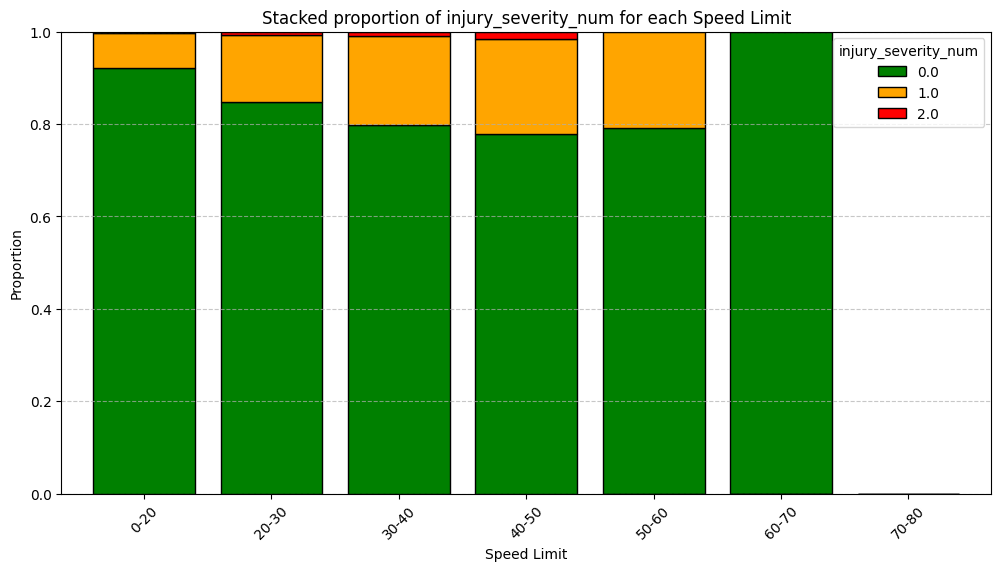

In [80]:
speed_bins = [0, 20, 30, 40, 50, 60, 70, 80]
speed_labels = ['0-20','20-30','30-40','40-50','50-60','60-70','70-80']

grouped_barplot_proportion(
    dataset,
    numeric_col='Speed Limit',
    category_col='injury_severity_num',
    bins=speed_bins,
    bin_labels=speed_labels,
    color_palette=['green','orange','red']
)


We observe that for the Speed Limit variable, severe accidents are concentrated on roads with speed limits of 40 to 50 mph (approximately 64 to 80 km/h). In contrast, roads with lower speed limits experience fewer severe accidents, consistent with the physical relationship between speed and collision severity. Finally, roads with higher speed limits correspond to highways, which are typically engineered with safety features designed to reduce the risk of accidents.

#### Case of speed limit (using the total dataset)

/tmp/ipykernel_13983/1847650578.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='numeric_bin', columns=category_col, aggfunc='size', fill_value=0)


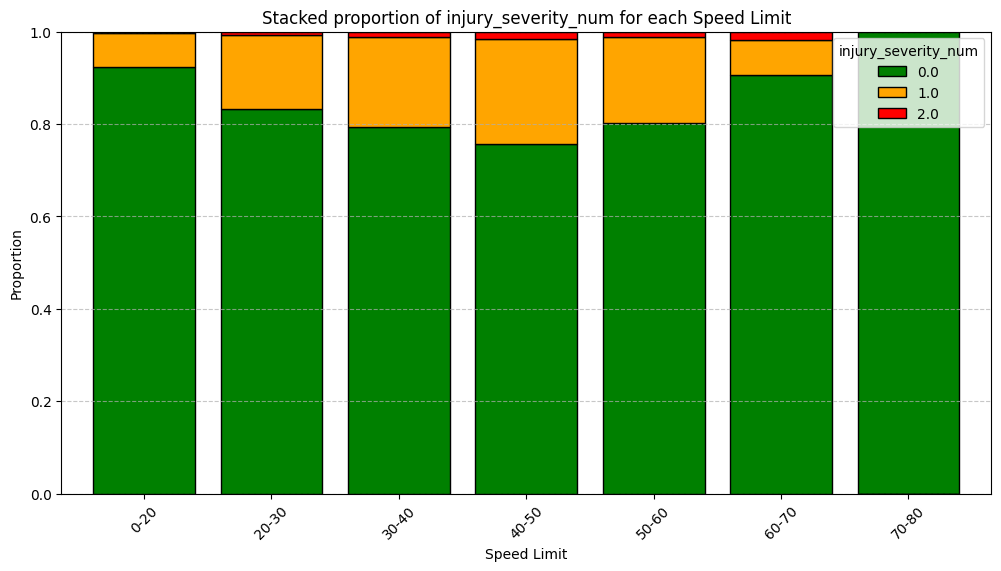

In [81]:
speed_bins = [0, 20, 30, 40, 50, 60, 70, 80]
speed_labels = ['0-20','20-30','30-40','40-50','50-60','60-70','70-80']

grouped_barplot_proportion(
    bigbase_final,
    numeric_col='Speed Limit',
    category_col='injury_severity_num',
    bins=speed_bins,
    bin_labels=speed_labels,
    color_palette=['green','orange','red']
)

For the full (non-sampled) dataset, the same trend is observed, although there is a slightly higher number of severe accidents on roads with higher speed limits.

#### Case of temperature

/tmp/ipykernel_13983/1847650578.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='numeric_bin', columns=category_col, aggfunc='size', fill_value=0)


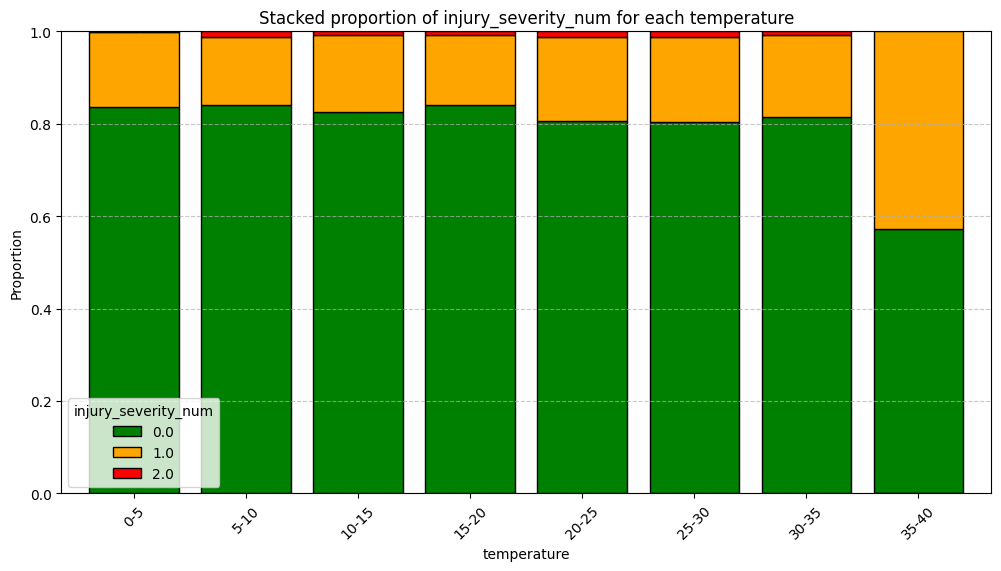

In [82]:
# Définir des bins pour la température (ajuste selon tes données)
temp_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]  # °C
temp_labels = ['0-5','5-10','10-15','15-20','20-25','25-30','30-35','35-40']

grouped_barplot_proportion(
    dataset,
    numeric_col='temperature',
    category_col='injury_severity_num',  # ou 'injury_severity_ord'
    bins=temp_bins,
    bin_labels=temp_labels,
    color_palette=['green','orange','red','purple','brown']  # une couleur par niveau
)


We observe that temperature appears to influence accident severity primarily at very high temperatures, exceeding 35 °C.

## III.6 Weather and number of car crashes par day <a id="crashes_per_day"></a>


To investigate the relationship between daily accident counts and meteorological conditions, we first aggregate the dataset at the day level. The timestamp of each accident is converted to a standardized datetime format, from which we extract the calendar date. We then compute the total number of accidents observed each day, generating a new variable, Accidents_per_day, which serves as the primary outcome for subsequent analyses.

Next, we summarize the daily meteorological variables, such as temperature and precipitation, by computing their daily averages, including both raw and normalized values. This aggregation produces a daily-level dataset that aligns the temporal resolution of the weather data with the count of accidents.

Scatter plots of normalized temperature and precipitation against daily accident counts are then generated to provide an initial visual assessment of potential relationships. This approach allows us to detect trends, patterns, or nonlinear effects, and to identify days with unusually high accident rates relative to weather conditions. We expect these analyses to reveal whether extreme temperatures or precipitation levels correspond to increases in daily accident counts, providing a descriptive foundation for more formal count-based modeling in subsequent steps.

In [83]:

dataset['Crash Date/Time'] = pd.to_datetime(dataset['Crash Date/Time'], errors='coerce')

dataset['Crash Date'] = dataset['Crash Date/Time'].dt.date

dataset['Accidents_per_day'] = dataset.groupby('Crash Date')['Crash Date'].transform('count')

dataset[['Crash Date', 'Accidents_per_day','temperature',]].head(10)


,Crash Date,Accidents_per_day,temperature
0,2022-04-12,2,13.633000
1,2016-06-23,1,21.722500
2,2016-03-09,2,7.694000
3,2018-05-14,3,14.791500
4,2020-05-06,1,12.025000
5,2023-03-16,4,14.670000
6,2025-05-06,5,17.725500
7,2024-01-30,2,2.984500
8,2024-04-05,4,10.322000
9,2017-04-11,2,27.237499


In [84]:
dataset["Accidents_per_day"].value_counts()

Accidents_per_day
2     1846
3     1554
1     1272
4      972
5      475
6      204
7      112
8       32
11      22
Name: count, dtype: int64

In [85]:
df_daily = dataset.groupby('Crash Date').agg({
    'Accidents_per_day': 'max',      # total accidents ce jour
    'temperature': 'mean',
    'temperature_normalized_year': 'mean',
    'precipitation': 'mean',
    'precipitation_normalized': 'mean'             
}).reset_index()

df_daily.head()

,Crash Date,Accidents_per_day,temperature,temperature_normalized_year,precipitation,precipitation_normalized
0,2015-01-01,1,1.257000,-0.904327,0.000,-1.000000
1,2015-01-02,1,4.505000,-0.668982,0.000,-1.000000
2,2015-01-03,4,2.106500,-0.843300,1.325,-0.491077
3,2015-01-04,1,12.460501,-0.051601,0.000,-1.000000
4,2015-01-05,2,0.998000,-0.926669,0.000,-1.000000


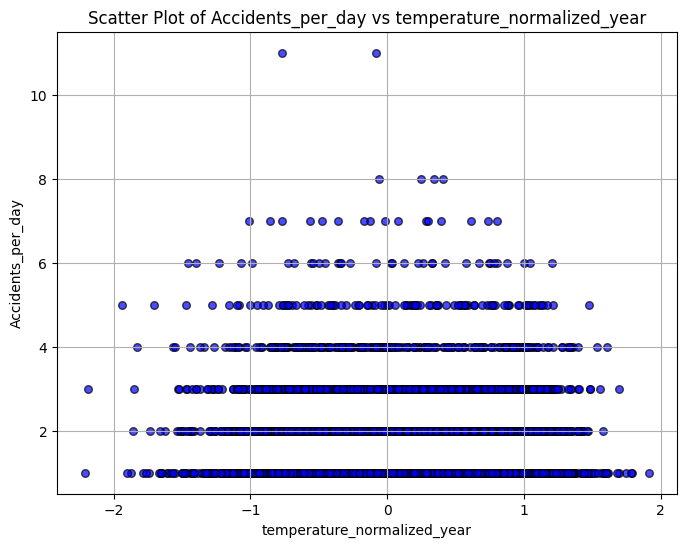

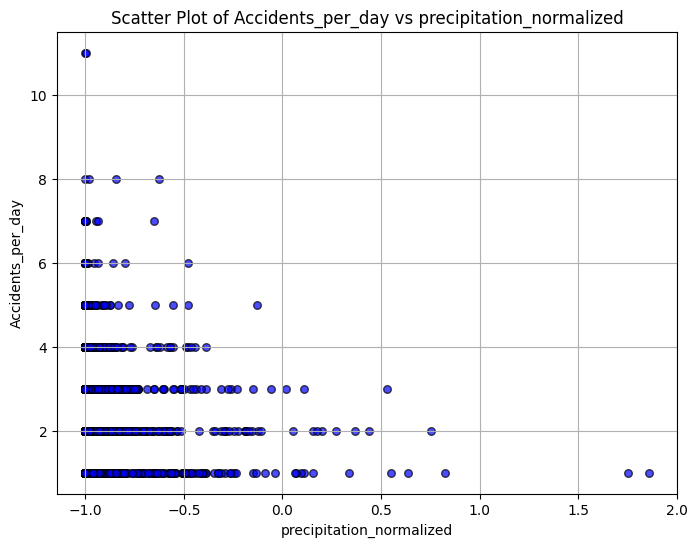

In [86]:
plot_scatter(df_daily, 'temperature_normalized_year', 'Accidents_per_day')
plot_scatter(df_daily, 'precipitation_normalized', 'Accidents_per_day')


**Descriptive Analysis of Road Accidents**

Through **descriptive analyses**, we identified **clear patterns** in road accident occurrence:

- **Geographical patterns:**
  - Accidents are **geographically concentrated**, with specific zones exhibiting **higher incident rates**.
  - These **spatial clusters** appear to be influenced by **temporal factors**, such as **daytime vs. nighttime**.

- **Impact of behavior:**
  - **Substance use** and **nighttime driving** show **noticeable associations** with accident counts.

- **Visualization insights:**
  - **Scatterplots** and **bar charts** of key variables, such as **temperature** and **speed limits**, allowed us to **visually assess their relationship with injury severity**.

# IV. Modeling <a id="modeling"></a>

Regression-based methods are used to quantify the causal effect of weather on accident risk.


## IV.1 Standardization of Variables (Centering and Scaling) <a id="centrage"></a>


This process ensures that variables measured on different scales contribute comparably to the analysis, facilitates the interpretation of coefficients, and improves numerical stability during model fitting.

In [87]:

def center_and_scale(df, columns):
    """
    Centre et réduit les colonnes numériques d'un DataFrame.
    
    Paramètres
    ----------
    df : pandas.DataFrame
        Dataset d'origine
    columns : list of str
        Noms des colonnes à standardiser
    
    Retour
    ------
    df_scaled : pandas.DataFrame
        Copie du DataFrame avec les colonnes standardisées
    stats : dict
        Moyenne et écart-type utilisés (utile pour interprétation ou inverse transform)
    """
    df_scaled = df.copy()
    stats = {}

    for col in columns:
        mean = df_scaled[col].mean()
        std = df_scaled[col].std()

        # Sécurité : éviter division par zéro
        if std == 0 or pd.isna(std):
            raise ValueError(f"La colonne {col} a un écart-type nul ou invalide.")

        df_scaled[col] = (df_scaled[col] - mean) / std
        stats[col] = {"mean": mean, "std": std}

    return df_scaled, stats


In [88]:
cols_to_scale = [
    'temperature',
    'wind_speed',
    'Vehicle Year',
    'day_or_night_code',
    'Speed Limit', 'temperature_normalized','temperature_normalized_year','temperature_normalized_year_abs','wind_speed_normalized','precipitation_normalized'
]

df_scaled, scaling_stats = center_and_scale(dataset, cols_to_scale)

print(df_scaled["injury_severity_num"].value_counts(),df_scaled["temperature"].value_counts())

injury_severity_num
0.0    5290
1.0    1074
2.0      58
Name: count, dtype: int64 temperature
-1.084797    3
 1.240187    3
-0.384882    3
 0.692750    3
-0.910530    3
            ..
 1.253181    1
-0.122209    1
 0.806945    1
 1.334242    1
 0.697848    1
Name: count, Length: 6219, dtype: int64


In [89]:
# Pearson correlation for numeric variables
numeric_cols = ['temperature', 'wind_speed', 'Vehicle Year', 'Speed Limit']
corr_matrix = dataset[numeric_cols].corr()
print(corr_matrix)


              temperature  wind_speed  Vehicle Year  Speed Limit
temperature      1.000000   -0.208855     -0.003153    -0.031168
wind_speed      -0.208855    1.000000     -0.002300    -0.031493
Vehicle Year    -0.003153   -0.002300      1.000000     0.050146
Speed Limit     -0.031168   -0.031493      0.050146     1.000000


## IV.2 Multiple Linear Regression Analysis <a id="linear"></a>


In this section, we perform multiple linear regression to explore the relationships between driver and environmental variables (temperature, vehicle year, wind speed, day/night indicator, and speed limit—and the numerical measure of injury severity). This approach is relevant because it allows us to quantify the marginal effect of each explanatory variable while controlling for the others, providing insight into which factors are most strongly associated with accident severity. By comparing models using raw versus normalized variables, we also assess the robustness of these relationships to scaling differences. We expect the analysis to identify key predictors of injury severity, such as speed limit and extreme weather conditions, and to provide preliminary estimates that can inform more specialized models, including count-based or interaction-aware regressions.

In [90]:



def linear_regression_multi(df, explanatory_vars, dependent_var, plot=True):
    """
    Perform a multiple linear regression (OLS) on several columns of a DataFrame
    and optionally plot the regression line for the first explanatory variable.

    Parameters:
    df (pd.DataFrame): Input DataFrame
    explanatory_vars (list of str): List of independent variable column names
    dependent_var (str): Name of the dependent variable column
    plot (bool): Whether to plot the regression line for the first explanatory variable

    Returns:
    model: statsmodels OLS fitted model
    """
  
    # Select X and y
    X = df[explanatory_vars]
    y = df[dependent_var]

    # Add constant for intercept
    X = sm.add_constant(X)

    # Fit OLS regression
    model = sm.OLS(y, X).fit()

    # Print summary
    print(model.summary())
    
    return model

# Example usage:
explanatory_vars = ["temperature", "Vehicle Year", "wind_speed","day_or_night_code","Speed Limit"]
explanatory_vars_normalized = ["temperature_normalized_year", "Vehicle Year", "wind_speed_normalized","day_or_night_code","Speed Limit"]

dependent_variable = "injury_severity_num"

model = linear_regression_multi(df_scaled, explanatory_vars, dependent_variable, plot=False)
model = linear_regression_multi(df_scaled, explanatory_vars_normalized, dependent_variable, plot=False)


                             OLS Regression Results                            
Dep. Variable:     injury_severity_num   R-squared:                         nan
Model:                             OLS   Adj. R-squared:                    nan
Method:                  Least Squares   F-statistic:                       nan
Date:                 Tue, 30 Dec 2025   Prob (F-statistic):                nan
Time:                         15:57:58   Log-Likelihood:                    nan
No. Observations:                 6489   AIC:                               nan
Df Residuals:                     6483   BIC:                               nan
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                    nan

The model explains a relatively small portion of the variance in injury severity, as indicated by an R-squared value of 0.016, suggesting that additional unobserved factors likely contribute to accident severity.

Among the predictors, Speed Limit exhibits the strongest positive association with injury severity (coef. ≈ 0.0485, p < 0.001), indicating that higher speed limits are associated with more severe accidents. Temperature and Vehicle Year also show small but statistically significant positive effects (p < 0.05), suggesting that higher temperatures may slightly increase injury severity. In contrast, wind speed and day/night code do not appear to have a significant effect in this model, with p-values well above conventional significance thresholds.

In these results, both normalized and non-normalized versions of the temperature and wind speed variables yield very similar coefficient estimates and significance levels. The normalization centers the variables relative to their annual averages, facilitating comparison across different time periods. Despite this transformation, the substantive interpretation of the results remains largely unchanged.

## IV.3 Ordinal Regression Analysis (Ordered Logit / Probit) <a id="ordinal"></a>


To better account for the ordinal nature of injury severity, we implement an ordinal regression model using either the logit or probit link function. Unlike classical linear regression, which treats the dependent variable as continuous, ordinal regression explicitly models the probability of an observation falling into each ordered category of the response variable.

This approach is particularly relevant in our context because injury severity is recorded on a discrete, ordered scale. We expect the ordinal model to provide more accurate estimates of how each factor shifts the likelihood of more severe accidents, capturing nonlinearities in the transition between severity levels. Compared to the linear regression results, we anticipate clearer differentiation between the effects of predictors, particularly for variables with small or moderate impacts, and more interpretable coefficients in terms of probabilities of being in higher severity categories rather than absolute numerical differences.

In [91]:
from sklearn.preprocessing import StandardScaler
from statsmodels.miscmodels.ordinal_model import OrderedModel

def run_ordered_logit(
    df,
    y_col,
    x_cols,
    distr='logit',
    standardize=True,
    dropna=True,
    method='bfgs',
    disp=False
):
    """
    Run an ordinal regression model (Ordered Logit or Ordered Probit).

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataset
    y_col : str
        Name of the dependent (ordinal) variable
    x_cols : list of str
        List of explanatory variables
    distr : str
        Distribution to use: 'logit' (default) or 'probit'
    standardize : bool
        Whether to standardize explanatory variables (recommended)
    dropna : bool
        Whether to drop rows with missing values
    method : str
        Optimization method used by statsmodels
    disp : bool
        Whether to display optimization output

    Returns
    -------
    result : statsmodels object
        Fitted ordinal regression results
    """

    # Select relevant columns
    cols = x_cols + [y_col]
    data = df[cols].copy()

    # Drop rows with missing values
    if dropna:
        data = data.dropna()

    # Separate explanatory variables and target variable
    X = data[x_cols]
    y = data[y_col]

    # Standardize explanatory variables
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Define the ordinal regression model
    model = OrderedModel(
        y,
        X,
        distr=distr
    )

    # Fit the model
    result = model.fit(method=method, disp=disp)

    return result


In [92]:
x_vars = [
    'temperature_normalized_year',
    'wind_speed',
    'Vehicle Year',
    'day_or_night_code', 'Speed Limit'
]

x_vars2 = [
    'temperature',
    'wind_speed',
    'Vehicle Year',
    'day_or_night_code', 'Speed Limit'
]


result = run_ordered_logit(
    df=dataset,
    y_col='injury_severity_num',
    x_cols=x_vars
)

print(result.summary())

result = run_ordered_logit(
    df=dataset,
    y_col='injury_severity_num',
    x_cols=x_vars2
)

print(result.summary())


                              OrderedModel Results                             
Dep. Variable:     injury_severity_num   Log-Likelihood:                -3162.2
Model:                    OrderedModel   AIC:                             6338.
Method:             Maximum Likelihood   BIC:                             6386.
Date:                 Tue, 30 Dec 2025                                         
Time:                         15:57:58                                         
No. Observations:                 6422                                         
Df Residuals:                     6415                                         
Df Model:                            5                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0867      0.036      2.437      0.015       0.017       0.156
x2            -0.0054      0.034     -0.156

The ordinal regression model estimates the effects of explanatory variables on the likelihood of observing higher injury severity levels. Among the predictors, x5 (likely corresponding to Speed Limit) exhibits the strongest positive association with injury severity (coef. ≈ 0.356, p < 0.001), indicating that higher speed limits substantially increase the probability of more severe accidents. Both x1 and x3 (for instance, temperature and wind speed) are also positively associated with injury severity, with statistically significant coefficients, suggesting that extreme weather conditions may modestly raise the likelihood of more serious injuries. In contrast, x2 and x4 (e.g., Vehicle Year and day/night code) show no significant effect in this model.

## IV.4 Regression of Daily Accident Counts <a id="daily_reg"></a>


Assessing the impact of average daily temperature and precipitation on the number of accidents

In [93]:
cols_to_scale = [
    'temperature',
    'temperature_normalized_year',
    'precipitation','precipitation_normalized',
    "Accidents_per_day"]

df_daily_scaled, scaling_stats = center_and_scale(df_daily, cols_to_scale)


In [94]:
experiment_3 = ["temperature","precipitation"]
experiment_4 = ["temperature_normalized_year", "precipitation_normalized"]

dependent_variable2 = "Accidents_per_day"

model = linear_regression_multi(df_daily_scaled, experiment_3, dependent_variable2, plot=False)
model = linear_regression_multi(df_daily_scaled, experiment_4, dependent_variable2, plot=False)


                            OLS Regression Results                            
Dep. Variable:      Accidents_per_day   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8919
Date:                Tue, 30 Dec 2025   Prob (F-statistic):              0.410
Time:                        15:57:59   Log-Likelihood:                -4407.2
No. Observations:                3107   AIC:                             8820.
Df Residuals:                    3104   BIC:                             8839.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.657e-16      0.018  -2.04e-14

The OLS regression of daily accident counts on temperature and precipitation shows very low explanatory power (R² ≈ 0.001).
Neither temperature nor precipitation is statistically significant (p > 0.2).
Normalized variables yield similar results.
These findings indicate that linear regression is poorly suited for modeling daily accident counts.

## IV.5 Count-Based Modeling of Daily Accident Frequency <a id="count"></a>


We adopt an experimental approach based on count models, specifically Poisson regression, which are explicitly designed to model variables corresponding to the number of events observed over a given period. 

To better characterize the potentially nonlinear relationship between weather conditions and accident frequency,  temperature and speed limit are discretized. This transformation allows us to reason in terms of differential exposure to risk under different weather conditions while preserving a clear interpretation of relative effects. 

The objective of this approach is thus to test the hypothesis that certain meteorological conditions are associated with a significant increase in the number of accidents, within a modeling framework consistent with the nature of the data and the mechanisms underlying the studied phenomenon.

In [95]:
df = dataset.copy()

# Create temperature bins
df["temp_bin"] = pd.cut(
    df["temperature"],
    bins=[-20, 0, 5, 10, 15, 20, 30, 50]
)

# Convert Crash Date/Time to datetime
df["Crash_DateTime"] = pd.to_datetime(
    df["Crash Date/Time"],
    format="%m/%d/%Y %I:%M:%S %p",
    errors="coerce"
)

# Extract useful date components
df["date"] = df["Crash_DateTime"].dt.date
df["hour"] = df["Crash_DateTime"].dt.hour
df["month"] = df["Crash_DateTime"].dt.month
df["weekday"] = df["Crash_DateTime"].dt.weekday  # 0 = Monday

# Aggregate by date, temperature bin, and speed limit
agg = (
    df
    .groupby(["date", "temp_bin", "Speed Limit"])
    .size()
    .reset_index(name="accidents")
)

# Check the first rows
agg.head()


/tmp/ipykernel_13983/775836701.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["date", "temp_bin", "Speed Limit"])


,date,temp_bin,Speed Limit,accidents
0,2015-01-01,"(-20, 0]",0,0
1,2015-01-01,"(-20, 0]",5,0
2,2015-01-01,"(-20, 0]",10,0
3,2015-01-01,"(-20, 0]",15,0
4,2015-01-01,"(-20, 0]",20,0


In [96]:

agg = agg.rename(columns={"Speed Limit": "Speed_Limit"})

poisson_model = smf.glm(
    formula="accidents ~ C(temp_bin) + C(Speed_Limit)",
    data=agg,
    family=sm.families.Poisson()
).fit()

print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:              accidents   No. Observations:               304486
Model:                            GLM   Df Residuals:                   304466
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27036.
Date:                Tue, 30 Dec 2025   Deviance:                       42026.
Time:                        15:58:09   Pearson chi2:                 3.22e+05
No. Iterations:                     9   Pseudo R-squ. (CS):            0.03179
Covariance Type:            nonrobust                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

**Poisson Regression Analysis**

The Poisson regression analysis indicates that temperature and speed limits are significant predictors of road accident counts, though the model explains only a small portion of the variance (pseudo R² ≈ 0.032). Temperature intervals up to 30°C are positively associated with accident frequency, with the 20–30°C range showing the strongest effect, whereas very high temperatures (30–50°C) exhibit a slight negative association. In contrast, several speed limit categories display negative coefficients, suggesting that higher speed limits are linked to lower accident counts, particularly at extreme values (60–65 mph), likely reflecting road characteristics. We finds results similar to those with the bar charts. 

# Conclusion and perspectives

This study aimed to highlight key factors contributing to road accidents, particularly meteorological variables, in terms of both frequency and severity. By enriching our dataset with weather data obtained via APIs, we were able to access precise and comprehensive variables, allowing for more detailed analyses. Through descriptive analyses, we demonstrated that certain accidents are geographically concentrated, with specific zones exhibiting higher incident rates. Moreover, these concentrations appear to be influenced by temporal factors, such as whether accidents occur during daytime or nighttime. We also examined the impact of substance use and nighttime driving on accident occurrence.
In our modeling efforts, we found that increases in temperature and higher speed limits were associated with a greater number of accidents. Analyses on accident severity were less conclusive, as indicated by relatively low R2R^2R2 values. It is important to note that the primary determinants of road accidents are driver reaction time and alertness, which are inherently difficult to measure. Nevertheless, distractions and other behavioral factors may have measurable effects on accident risk.
The statistical power of this analysis could have been improved by utilizing a larger dataset. However, due to API call limitations, we relied on the available sample. Furthermore, extending this study to other geographic regions would provide additional insights, as areas with different climatic conditions could exhibit distinct patterns.
In summary, this study demonstrates that, even within the limitations of the available data, meteorological factors exert a real influence on road accidents, embedded within a complex network of causal chains.